In [1]:
%matplotlib inline
import sys, os, glob

from astropy.io import fits, ascii

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy import units as u
from astropy.table import Table
import astropy.constants as const
from astropy.coordinates import SkyCoord, concatenate
from astropy import table

from astropy.cosmology import FlatLambdaCDM, z_at_value
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

import scipy.stats as st
from scipy.special import erf, gamma, gammainc

from scipy.optimize import minimize

from scipy.interpolate import interp1d
from scipy.integrate import trapezoid, cumulative_trapezoid
from scipy.signal import fftconvolve


import emcee
import corner

In [2]:
from astroquery.vizier import Vizier
from astroquery.simbad import Simbad
Vizier.ROW_LIMIT = -1
Simbad.TIMEOUT = 800 # seconds

In [3]:
import scienceplots

plt.style.use(['science', 'no-latex', 'notebook', 'light'])

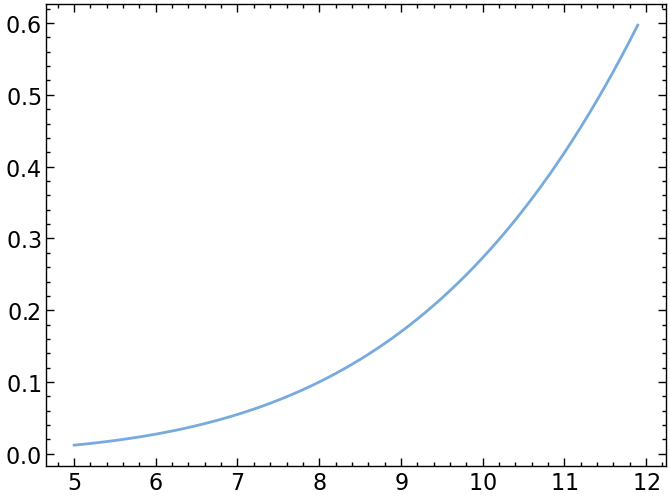

In [4]:
x_eval = np.arange(5, 12, .1)
plt.plot(x_eval, .1 * (x_eval/8)**4.5)

In [5]:
def f_x(x, x0, f_a=1, delta=1, theta=2.5, c=4.5):
    
    # Occupation function (Miller 2015)
    #focc = 1/2*(1 + np.tanh(2.5**np.abs(8.9 - x0) * (x - x0)))

    A = np.clip(f_a * (x/8)**c, 0, 1)
    
    focc = A/(1 + delta * np.exp(-theta*(x - x0)))**(1/delta)
    
    return f_a * focc

In [6]:
Gamma = 1.8

### Chandra Source Catalog 2

In [7]:
hdul = fits.open('catalog.fits')
data_50Mpc = Table(hdul[1].data)
cat_50Mpc = SkyCoord(data_50Mpc['ra'], data_50Mpc['dec'], unit='deg')

table_csc = Table([cat_50Mpc.ra.deg, cat_50Mpc.dec.deg], names=['ra', 'dec'])
table_csc.write('table_csc.xml', format='votable', overwrite=True)

###########################
#r_match = 2.5*u.arcsec #### way too high
r_match = 0.5*u.arcsec #### 0.5 -1 is the sweet spot

###########################


In [8]:
data_50Mpc

<Table length=15424>
        objname           pgc   ... chandra_detection_3arcsec log_lx_3arcsec
         str29           int32  ...          float64             float64    
----------------------- ------- ... ------------------------- --------------
 2MASXJ01235631+0012308 3519080 ...                       0.0            nan
 2MASXJ04575930-0612323 3689848 ...                       0.0            nan
 2MASXJ05534289-3205449 3704923 ...                       0.0            nan
 2MASXJ06094464-3250007 3707868 ...                       0.0            nan
 2MASXJ07415401+2352188 3723606 ...                       0.0            nan
 2MASXJ08241658+2710571 3729986 ...                       0.0            nan
 2MASXJ09343407+1300201 3743904 ...                       0.0            nan
 2MASXJ09370295+6609161 3744472 ...                       0.0            nan
 2MASXJ09383447+0853159 3531206 ...                       0.0            nan
 2MASXJ09445892+0822116 3460270 ...                       0.0            nan
                    ...     ... ...                       ...            ...
SDSSJ175211.29+243059.0      -1 ...                       0.0            nan
SDSSJ181914.60+125504.9      -1 ...                       0.0            nan
SDSSJ201514.41+090721.2      -1 ...                       0.0            nan
SDSSJ215118.06+711320.1      -1 ...                       0.0            nan
SDSSJ012102.70+260517.0      -1 ...                       0.0            nan
SDSSJ023330.49+270105.9      -1 ...                       0.0            nan
SDSSJ024055.00+263957.9      -1 ...                       0.0            nan
SDSSJ121814.50+134445.9      -1 ...                       0.0            nan
SDSSJ133850.79+080637.9      -1 ...                       0.0            nan
SDSSJ010555.45-025135.9      -1 ...                       0.0            nan

In [9]:
from astropy.io.votable import parse
csc_results = parse("cscresults.9.vot").get_first_table().to_table(use_names_over_ids=True)
csc_results

<Table length=1098>
usrid separation probability ... flux_aper_avg_lolim_w flux_aper_avg_hilim_w
        arcsec               ...       erg/s/cm^2            erg/s/cm^2     
int32  float64     float64   ...        float64               float64       
----- ---------- ----------- ... --------------------- ---------------------
   45       0.31        0.06 ...                    --                    --
   54       0.23        0.70 ...                    --                    --
  300       1.01        0.00 ...                    --                    --
  445       0.18        0.14 ...                    --                    --
  445       1.04        0.00 ...                    --                    --
  445       2.29        0.00 ...                    --                    --
  445       2.94        0.00 ...                    --                    --
  445       3.11        0.00 ...                    --                    --
  445       3.69        0.00 ...                    --                    --
  ...        ...         ... ...                   ...                   ...
14227       3.75        0.00 ...                    --                    --
14256       2.92        0.00 ...                    --                    --
14350       0.92        0.12 ...                    --                    --
14631       0.66        0.00 ...                    --                    --
14670       0.87        0.00 ...                    --                    --
14745       0.91        0.06 ...                    --                    --
15035       2.49        0.00 ...                    --                    --
15087       4.77        0.00 ...                     0              8.14e-15
15117       4.50        0.00 ...                     0              8.57e-16
15119       4.12        0.00 ...                     0              1.07e-15

In [10]:
from astropy.io.votable import parse
csc_results = parse("cscresults.9.vot").get_first_table().to_table(use_names_over_ids=True)
csc_results

# Compact only and valid hard-band flux
mask = (csc_results['extent_flag'] == 0) & np.isfinite(csc_results['flux_aper_h']) & (csc_results['flux_aper_h'] > 0.0)
csc_results = csc_results[mask]

# Re-do the matching
cat_result = SkyCoord(csc_results['ra'], csc_results['dec'], unit='deg')
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, r_match)

# These are stacked fluxes
fx = csc_results['flux_aper_h'][idx_result].data.data
fx_lo = csc_results['flux_aper_lolim_h'][idx_result].data.data
fx_hi = csc_results['flux_aper_hilim_h'][idx_result].data.data

print(len(csc_results))

fx_err = np.nanmean([fx-fx_lo, fx_hi-fx], axis=0)

d = (data_50Mpc['bestdist'][idx_50Mpc]*u.Mpc).to(u.cm).value
d_err = (data_50Mpc['bestdist_error'][idx_50Mpc]*u.Mpc).to(u.cm).value
log_lx_idx_result = np.log10(fx*4*np.pi*d**2)
lx_err = fx*4*np.pi*d**2 * np.sqrt((fx_err/fx)**2 + 2*(d_err/d)**2) # l df / f
log_lx_err_idx_result = 0.434*lx_err / 10**log_lx_idx_result
data_50Mpc['log_lx_csc'] = -1.0
data_50Mpc['log_lx_err_csc'] = -1.0

data_50Mpc['log_lx_csc'][idx_50Mpc] = log_lx_idx_result
data_50Mpc['log_lx_err_csc'][idx_50Mpc] = log_lx_err_idx_result

print(len(data_50Mpc['log_lx_csc'][data_50Mpc['log_lx_csc']>0]))
# 

620
146


In [11]:
data_50Mpc['log_lx_err_csc'][(data_50Mpc['log_lx_err_csc']!=-1) & (data_50Mpc['log_lx_err_csc']<0)]

<Column name='log_lx_err_csc' dtype='float64' length=0>

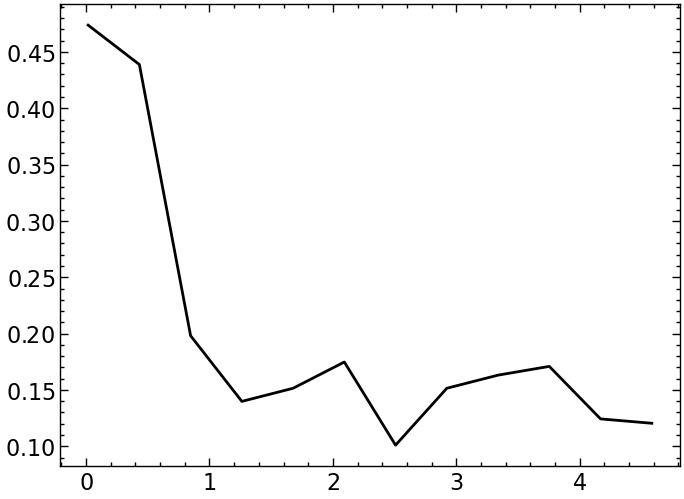

In [12]:
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, 10*u.arcsec)
h, bin_edges = np.histogram(d2d.to(u.arcsec).value, bins=12)
# plot the cumulative function
#plt.plot(bin_edges[:-1], np.cumsum(h/np.sum(h*np.diff(bin_edges))), c='blue')
plt.plot(bin_edges[:-1], h/np.sum(h*np.diff(bin_edges)), c='k')

In [13]:
# Extended and valid hard-band flux
mask = (csc_results['extent_flag'] == 1) & np.isfinite(csc_results['flux_aper_h']) & (csc_results['flux_aper_h'] > 0.0)
csc_results = csc_results[mask]

# Re-do the matching
cat_result = SkyCoord(csc_results['ra'], csc_results['dec'], unit='deg')
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc[data_50Mpc['log_lx_csc']==-1].search_around_sky(cat_result, r_match)

# These are stacked fluxes 
fx = csc_results['flux_aper_h'][idx_result].data.data
data_50Mpc['log_lx_csc'][idx_50Mpc] = fx
# No error = upper limit

In [14]:
from astropy.io.votable import parse
csc_results_sens = parse("csclimsen.vot").get_first_table().to_table(use_names_over_ids=True)

# valid hard-band flux sensitivity
mask = (csc_results_sens['flux_sens_h'] > 0.0) & np.isfinite(csc_results_sens['flux_sens_h'])

csc_results_sens = csc_results_sens[mask]
# Re-do the matching
cat_result = SkyCoord(csc_results_sens['ra'], csc_results_sens['dec'], unit='deg')
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, r_match)

# Includes marginal detections
# Stacked upper limits?
d = (data_50Mpc['bestdist'][idx_50Mpc]*u.Mpc).to(u.cm).value
log_lx_sens_idx_result = np.log10(1 * csc_results_sens['flux_sens_h'][idx_result]*4*np.pi*d**2)

data_50Mpc['log_lx_sens'] = -1.0 
data_50Mpc['log_lx_sens'][idx_50Mpc] = log_lx_sens_idx_result 

# TODO OK, the sensitivity limit could be too strict if there is a detection that just wans't matched properly

/home/cjb232/.conda/envs/cjb232base/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


nan


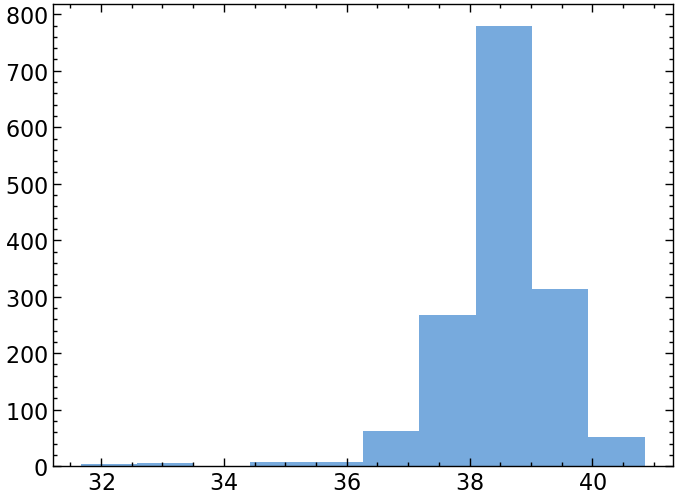

In [15]:
plt.hist(log_lx_sens_idx_result[log_lx_sens_idx_result< 50])
print(np.median(log_lx_sens_idx_result))

In [16]:
csc_results

<Table length=0>
usrid separation probability ... flux_aper_avg_lolim_w flux_aper_avg_hilim_w
        arcsec               ...       erg/s/cm^2            erg/s/cm^2     
int32  float64     float64   ...        float64               float64       
----- ---------- ----------- ... --------------------- ---------------------

In [17]:
# 393

### XMM-SSC DR16 

In [18]:
result_table = Vizier(catalog="xmm4d13s", timeout=3600,
                      columns=['RA_ICRS', 'DE_ICRS', 'Flux8', 'e_Flux8', 'ext'], column_filters={'Flux8':'>0', 'ext':'==0', 'S':'==0'}).query_region(cat_50Mpc, radius=10*u.arcsec)
result_table[0]

<Table length=189>
  _q   RA_ICRS    DE_ICRS      Flux8       e_Flux8       ext   
         deg        deg       mW / m2      mW / m2      arcsec 
int32  float64    float64     float64      float64     float64 
----- ---------- ---------- ------------ ------------ ---------
   89 190.013035 -11.667881   1.0645e-14   3.8631e-15  0.000000
  181 145.534624 -23.595037   5.6273e-14   2.6975e-14  0.000000
  547 200.759412 -41.785994   4.7306e-15   3.6701e-15  0.000000
  901 280.888255 -64.106998   2.9622e-14   1.1888e-14  0.000000
 1199  69.902629 -53.013462   8.8771e-14   1.1868e-14  0.000000
 1273 287.938394 -57.135071   6.1998e-15   2.5947e-15  0.000000
 1273 287.941753 -57.133789   1.4612e-14   2.3346e-15  0.000000
 1325   5.659929 -48.579187   1.5742e-14   9.4792e-15  0.000000
 2013  50.593984 -37.397356    1.823e-14   4.3303e-15  0.000000
  ...        ...        ...          ...          ...       ...
27631 138.680705  40.881751   2.0617e-14   2.1444e-14  0.000000
27651 139.337060  41.911870   3.7475e-14   2.7933e-14  0.000000
27819 149.857570  30.744903   3.4004e-14   1.2978e-14  0.000000
28185 167.301289  61.396082   1.8399e-14   4.4954e-15  0.000000
28529 180.513459  29.850204   4.0957e-14   1.3313e-14  0.000000
28531 180.594602  29.861584   2.2945e-13    1.298e-13  0.000000
29261 215.863275   1.726294   1.1029e-13   4.1519e-14  0.000000
29489 234.134572  16.441873   1.2358e-13   7.5855e-15  0.000000
30069 143.508147  55.241213   3.1171e-13   7.1019e-15  0.000000
30811 186.312157  12.714073   1.2144e-14   4.8984e-15  0.000000

In [19]:
c_xmm = (10**(2-Gamma) - 2**(2-Gamma))/(12**(2-Gamma) - 0.2**(2-Gamma))

# Re-do the matching
cat_result = SkyCoord(result_table[0]['RA_ICRS'], result_table[0]['DE_ICRS'])
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, 1.0*u.arcsec)

data_50Mpc['log_lx_xmm'] = -1.0
data_50Mpc['log_lx_err_xmm'] = -1.0

fx = result_table[0]['Flux8'][idx_result].data.data
fx_err = result_table[0]['e_Flux8'][idx_result].data.data

d = (data_50Mpc['bestdist'][idx_50Mpc]*u.Mpc).to(u.cm).value
d_err = (data_50Mpc['bestdist_error'][idx_50Mpc]*u.Mpc).to(u.cm).value
log_lx_idx_result = np.log10(c_xmm * fx*4*np.pi*d**2)
lx_err = c_xmm * fx*4*np.pi*d**2 * np.sqrt((fx_err/fx)**2 + 2*(d_err/d)**2) # l df / f
log_lx_err_idx_result = 0.434*lx_err / 10**log_lx_idx_result

data_50Mpc['log_lx_xmm'][idx_50Mpc] = log_lx_idx_result
data_50Mpc['log_lx_err_xmm'][idx_50Mpc] = log_lx_err_idx_result

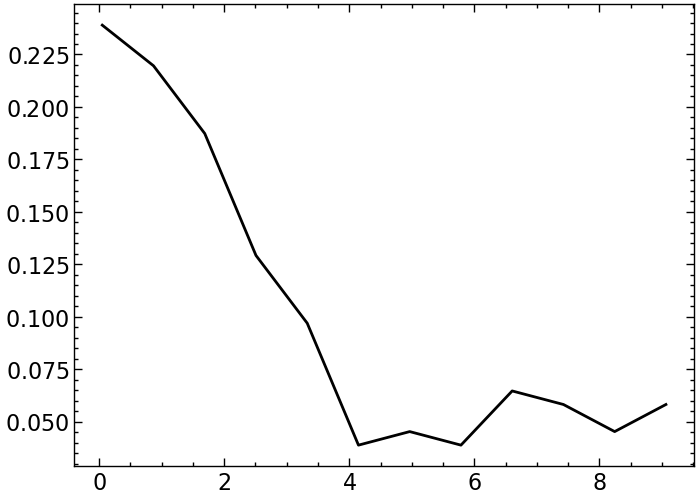

In [20]:
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, 10*u.arcsec)
h, bin_edges = np.histogram(d2d.to(u.arcsec).value, bins=12)
# plot the cumulative function
#plt.plot(bin_edges[:-1], np.cumsum(h/np.sum(h*np.diff(bin_edges))), c='blue')
plt.plot(bin_edges[:-1], h/np.sum(h*np.diff(bin_edges)), c='k')

### EROSITA detections / upper-limits

https://erosita.mpe.mpg.de/dr1/erodat/upperlimit/multi/

In [21]:
result_table = Vizier(catalog="J/A+A/682/A34/erass1-h", timeout=3600,
                      columns=['RA_ICRS', 'DE_ICRS', 'MLFlux3', 's_MLFlux3'], column_filters={'MLFlux3':'>0', 'EXT':'==0'}).query_region(cat_50Mpc, radius=10*u.arcsec)
result_table[0]

<Table length=32>
  _q      RA_ICRS         DE_ICRS         MLFlux3        s_MLFlux3   
            deg             deg           mW / m2         mW / m2    
int32     float64         float64         float64         float64    
----- --------------- --------------- --------------- ---------------
  445 213.29081042840 -65.33955296099   1.5775043e-12   3.7837883e-13
  485  91.87657510644 -61.80548118418   1.6894508e-13   5.7176011e-14
 1370 168.13927480491 -36.42546026037   1.1192108e-12   3.4072826e-13
 1446 203.97396719904 -34.29562746049      1.4477e-11   1.0375033e-12
 1628 146.91737027061 -30.94938045434   2.6718346e-11   1.8391846e-12
 1651 158.66199050652 -28.58125786527   7.5714722e-13   3.1319169e-13
 2107 221.23722773092 -23.79450049082    1.867087e-12   3.9962933e-13
 2771 139.99245991208  37.18994614620   9.8640356e-13   4.1689186e-13
 3492  41.57866105247 -30.27387316662   1.0210678e-12   2.6587464e-13
  ...             ...             ...             ...             ...
 4772 189.91412905730  -5.34408569376   1.5774714e-12   4.2916275e-13
 5006 200.07113784357 -21.82658825910   4.5701621e-13   2.0620101e-13
 5029 201.36558806000 -43.01941111293   2.2528793e-11   1.3112487e-12
 5135 211.72968747356  -5.46036108944   7.3995649e-13   2.4771957e-13
 5153 213.31241206759  -3.20776502147   1.8006301e-11   1.2209965e-12
 5360 253.19306329687 -59.21738095005   2.6855996e-12   5.1596157e-13
 5372 259.24525244647 -62.81997958890   1.3977632e-12     3.82163e-13
 5560 332.31858556399 -47.16643035417   5.5299329e-12   8.5571773e-13
 8964  52.29291177473 -22.02162731122   6.2298674e-13   2.1502072e-13
 9134 212.63987663678 -52.31762175483   9.1575326e-13   1.9412458e-13

In [22]:
c_erosita = (10**(2-Gamma) - 2**(2-Gamma))/(5.0**(2-Gamma) - 2.3**(2-Gamma))

# Re-do the matching
cat_result = SkyCoord(result_table[0]['RA_ICRS'], result_table[0]['DE_ICRS'])
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, 1.5*u.arcsec)

data_50Mpc['log_lx_erosita'] = -1.0
data_50Mpc['log_lx_err_erosita'] = -1.0

fx = result_table[0]['MLFlux3'][idx_result].data.data
fx_err = result_table[0]['s_MLFlux3'][idx_result].data.data

d = (data_50Mpc['bestdist'][idx_50Mpc]*u.Mpc).to(u.cm).value
d_err = (data_50Mpc['bestdist_error'][idx_50Mpc]*u.Mpc).to(u.cm).value
log_lx_idx_result = np.log10(c_erosita * fx*4*np.pi*d**2)
lx_err = c_erosita * fx*4*np.pi*d**2 * np.sqrt((fx_err/fx)**2 + 2*(d_err/d)**2) # l df / f
log_lx_err_idx_result = 0.434*lx_err / 10**log_lx_idx_result

data_50Mpc['log_lx_erosita'][idx_50Mpc] = log_lx_idx_result
data_50Mpc['log_lx_err_erosita'][idx_50Mpc] = log_lx_err_idx_result

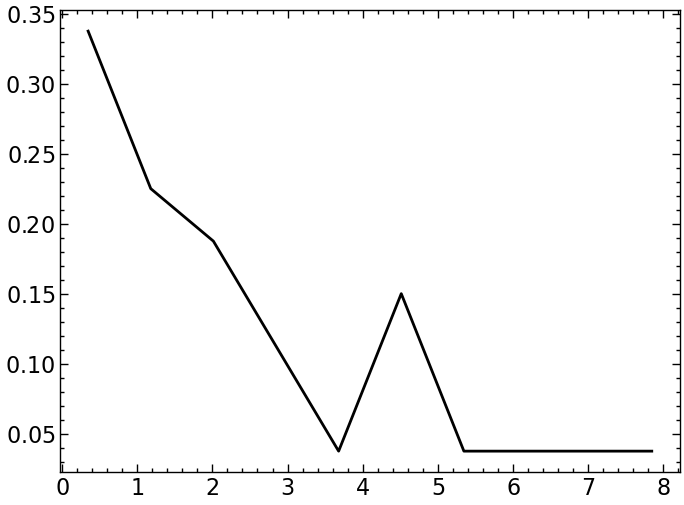

In [23]:
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, 10*u.arcsec)
h, bin_edges = np.histogram(d2d.to(u.arcsec).value, bins=10)
# plot the cumulative function
#plt.plot(bin_edges[:-1], np.cumsum(h/np.sum(h*np.diff(bin_edges))), c='blue')
plt.plot(bin_edges[:-1], h/np.sum(h*np.diff(bin_edges)), c='k')

### ROSAT detections / upper-limits

In [24]:
result_table = Vizier(catalog="J/A+A/588/A103/cat2rxs", timeout=3600,
                      columns=['RAJ2000', 'DEJ2000', 'CRate', 'e_CRate'], column_filters={'CRate':'>0', 'Masked':'=1', 'Sflag':'0'}).query_region(cat_50Mpc, radius=30*u.arcsec)
result_table[0]

<Table length=175>
  _q   RAJ2000   DEJ2000   CRate   e_CRate
         deg       deg     ct / s   ct / s
int32  float64   float64  float64  float32
----- --------- --------- -------- -------
   68  25.71946 -43.40153   0.0626  0.0150
   75  65.32997 -31.63378   0.0418  0.0120
  445 213.28643 -65.33929   0.0739  0.0155
 1446 203.97544 -34.29518   3.2196  0.1055
 1516   1.38883 -28.09860   0.0260  0.0122
 1552  85.88376 -27.65407   0.0398  0.0107
 1581 109.13041 -29.32075   0.0243  0.0107
 1628 146.91835 -30.94832   0.2583  0.0244
 1933 124.81333 -25.18575   0.0543  0.0149
  ...       ...       ...      ...     ...
12239 144.54870   7.72177   0.0333  0.0130
12891 196.22240  49.11728   0.0385  0.0113
13526  57.56624  70.09762   0.0139  0.0064
13646 109.87638  59.35393   0.0196  0.0092
13670 113.54931   4.55094   0.0222  0.0097
14147 172.02718  78.99782   0.0444  0.0104
14201 176.31795  79.68188   0.3774  0.0266
14701 225.29563  44.69869   0.0215  0.0073
15026 358.88289  17.91807   0.0182  0.0080
15272 246.82368  29.65526   0.0598  0.0126

In [25]:
c_rosat = (10**(2-Gamma) - 2**(2-Gamma))/(2.4**(2-Gamma) - 0.1**(2-Gamma))

# Re-do the matching
cat_result = SkyCoord(result_table[0]['RAJ2000'], result_table[0]['DEJ2000'])
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, 10*u.arcsec)

data_50Mpc['log_lx_rosat'] = -1.0
data_50Mpc['log_lx_err_rosat'] = -1.0

fx = 1.0e-11 * result_table[0]['CRate'][idx_result].data.data
fx_err = 1.0e-11 * result_table[0]['e_CRate'][idx_result].data.data

d = (data_50Mpc['bestdist'][idx_50Mpc]*u.Mpc).to(u.cm).value
d_err = (data_50Mpc['bestdist_error'][idx_50Mpc]*u.Mpc).to(u.cm).value
log_lx_idx_result = np.log10(c_rosat * fx*4*np.pi*d**2)
lx_err = c_rosat * fx*4*np.pi*d**2 * np.sqrt((fx_err/fx)**2 + 2*(d_err/d)**2) # l df / f
log_lx_err_idx_result = 0.434*lx_err / 10**log_lx_idx_result

data_50Mpc['log_lx_rosat'][idx_50Mpc] = log_lx_idx_result
#### data_50Mpc['log_lx_err_rosat'][idx_50Mpc] = log_lx_err_idx_result ########
# Too inaccurate to be reliable

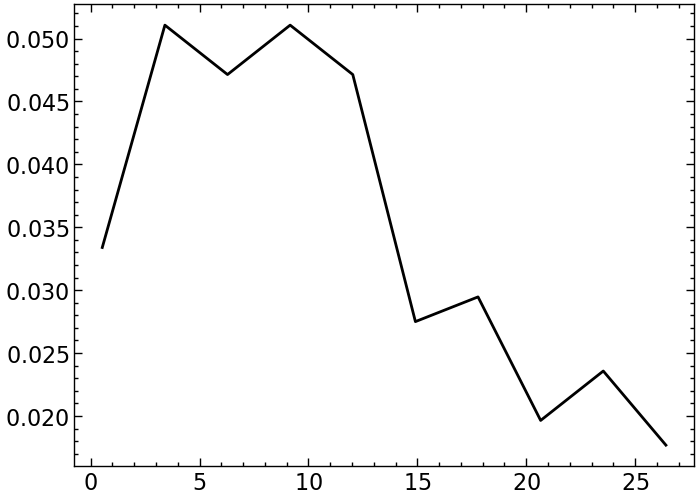

In [26]:
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, 30*u.arcsec)
h, bin_edges = np.histogram(d2d.to(u.arcsec).value, bins=10)
# plot the cumulative function
#plt.plot(bin_edges[:-1], np.cumsum(h/np.sum(h*np.diff(bin_edges))), c='blue')
plt.plot(bin_edges[:-1], h/np.sum(h*np.diff(bin_edges)), c='k')

### Combine X-ray data

  log_lx_erosita  
------------------
0.8850486254068457
0.8147849576758688
0.04516822432997003
0.250684634731834


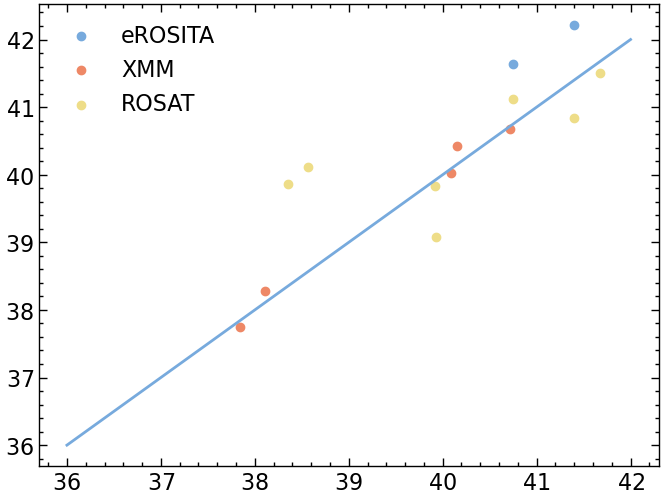

In [27]:
plt.scatter(data_50Mpc['log_lx_csc'][(data_50Mpc['log_lx_csc']!=-1) & (data_50Mpc['log_lx_erosita']!=-1)],
            data_50Mpc['log_lx_erosita'][(data_50Mpc['log_lx_csc']!=-1) & (data_50Mpc['log_lx_erosita']!=-1)], label='eROSITA')
dy = data_50Mpc['log_lx_erosita'][(data_50Mpc['log_lx_csc']!=-1) & (data_50Mpc['log_lx_erosita']!=-1)] - data_50Mpc['log_lx_csc'][(data_50Mpc['log_lx_csc']!=-1) & (data_50Mpc['log_lx_erosita']!=-1)]
print(dy)

plt.scatter(data_50Mpc['log_lx_csc'][(data_50Mpc['log_lx_csc']!=-1) & (data_50Mpc['log_lx_xmm']!=-1)],
            data_50Mpc['log_lx_xmm'][(data_50Mpc['log_lx_csc']!=-1) & (data_50Mpc['log_lx_xmm']!=-1)], label='XMM')
dy = data_50Mpc['log_lx_xmm'][(data_50Mpc['log_lx_csc']!=-1) & (data_50Mpc['log_lx_xmm']!=-1)] - data_50Mpc['log_lx_csc'][(data_50Mpc['log_lx_csc']!=-1) & (data_50Mpc['log_lx_xmm']!=-1)]
print(np.mean(dy))

plt.scatter(data_50Mpc['log_lx_csc'][(data_50Mpc['log_lx_csc']!=-1) & (data_50Mpc['log_lx_rosat']!=-1)],
            data_50Mpc['log_lx_rosat'][(data_50Mpc['log_lx_csc']!=-1) & (data_50Mpc['log_lx_rosat']!=-1)], label='ROSAT')
dy = data_50Mpc['log_lx_rosat'][(data_50Mpc['log_lx_csc']!=-1) & (data_50Mpc['log_lx_rosat']!=-1)] - data_50Mpc['log_lx_csc'][(data_50Mpc['log_lx_csc']!=-1) & (data_50Mpc['log_lx_rosat']!=-1)]
print(np.mean(dy))

plt.plot([36, 42], [36, 42])
plt.legend()

In [28]:
print(c_xmm)
print(c_erosita)
print(c_rosat)


data_50Mpc['r_match'] = np.full(len(data_50Mpc), 0.5)

# Set flux
data_50Mpc['_log_lx'] = data_50Mpc['log_lx_csc'].copy() # Assign Chandra luminosity
print(len(data_50Mpc['_log_lx'][data_50Mpc['_log_lx']>-1]))
print('CSS')
data_50Mpc['r_match'][(data_50Mpc['_log_lx']==-1)] = 1.0
data_50Mpc['_log_lx'][data_50Mpc['_log_lx']==-1] = data_50Mpc['log_lx_xmm'][data_50Mpc['_log_lx']==-1].copy() # Assign XMM luminosity
print(len(data_50Mpc['_log_lx'][data_50Mpc['_log_lx']>-1]))
print('XMM')
data_50Mpc['r_match'][(data_50Mpc['_log_lx']==-1) & (data_50Mpc['log_lx_sens']==-1)] = 1.5
data_50Mpc['_log_lx'][(data_50Mpc['_log_lx']==-1) & (data_50Mpc['log_lx_sens']==-1)] = data_50Mpc['log_lx_erosita'][(data_50Mpc['_log_lx']==-1) & (data_50Mpc['log_lx_sens']==-1)].copy() # Assign eROSITA luminosity
print(len(data_50Mpc['_log_lx'][data_50Mpc['_log_lx']>-1]))
print('eROSITA')
data_50Mpc['r_match'][(data_50Mpc['_log_lx']==-1) & (data_50Mpc['log_lx_sens']==-1)] = 10
data_50Mpc['_log_lx'][(data_50Mpc['_log_lx']==-1) & (data_50Mpc['log_lx_sens']==-1)] = data_50Mpc['log_lx_rosat'][(data_50Mpc['_log_lx']==-1) & (data_50Mpc['log_lx_sens']==-1)].copy() # Assign ROSAT luminosity
print(len(data_50Mpc['_log_lx'][data_50Mpc['_log_lx']>-1]))
print('ROSAT')

c_erosita_UL = (10**(2-Gamma) - 2**(2-Gamma))/(2.3**(2-Gamma) - 0.2**(2-Gamma))

# Assign Upper limits
# Defaults to -1, order matters
# CSC 2
#####################
data_50Mpc['_log_lx'][data_50Mpc['_log_lx']==-1] = data_50Mpc['log_lx_sens'][data_50Mpc['_log_lx']==-1].copy()
#####################
# eROSITA
mask_erosita = (cat_50Mpc.galactic.l.deg < 359) & (cat_50Mpc.galactic.l.deg > 179)
d = (data_50Mpc['bestdist'][(data_50Mpc['_log_lx']==-1) & mask_erosita]*u.Mpc).to(u.cm).value
data_50Mpc['_log_lx'][(data_50Mpc['_log_lx']==-1) & mask_erosita] = np.log10(1 * 1e-14*4*np.pi*d**2) # ~ 1e-14
# ROSAT 2RXS
d = (data_50Mpc['bestdist'][data_50Mpc['_log_lx']==-1]*u.Mpc).to(u.cm).value
data_50Mpc['_log_lx'][data_50Mpc['_log_lx']==-1] = np.log10(1 * 1e-13*4*np.pi*d**2*c_rosat) # ~ 1e-13

# Errors
data_50Mpc['log_lx_err_xmm'][data_50Mpc['log_lx_err_xmm']!=-1] = np.log10(10**(data_50Mpc['log_lx_err_xmm'][data_50Mpc['log_lx_err_xmm']!=-1]))
data_50Mpc['log_lx_err_erosita'][data_50Mpc['log_lx_err_erosita']!=-1] = np.log10(10**(data_50Mpc['log_lx_err_erosita'][data_50Mpc['log_lx_err_erosita']!=-1]))
data_50Mpc['log_lx_err_rosat'][data_50Mpc['log_lx_err_rosat']!=-1] = np.log10(10**(data_50Mpc['log_lx_err_rosat'][data_50Mpc['log_lx_err_rosat']!=-1]))

# Defaults to -1, order matters
data_50Mpc['_log_lx_err'] = data_50Mpc['log_lx_err_csc'].copy()
data_50Mpc['_log_lx_err'][data_50Mpc['_log_lx_err']==-1] = data_50Mpc['log_lx_err_xmm'][data_50Mpc['_log_lx_err']==-1].copy()
data_50Mpc['_log_lx_err'][data_50Mpc['_log_lx_err']==-1] = data_50Mpc['log_lx_err_erosita'][data_50Mpc['_log_lx_err']==-1].copy()
data_50Mpc['_log_lx_err'][data_50Mpc['_log_lx_err']==-1] = data_50Mpc['log_lx_err_rosat'][data_50Mpc['_log_lx_err']==-1].copy()

0.47465511326514587
2.19779309105722
0.778362609733939
146
CSS
180
XMM
186
eROSITA
206
ROSAT


(array([1.5700e+03, 6.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.3848e+04]),
 array([ 0.5 ,  1.45,  2.4 ,  3.35,  4.3 ,  5.25,  6.2 ,  7.15,  8.1 ,
         9.05, 10.  ]),
 <BarContainer object of 10 artists>)

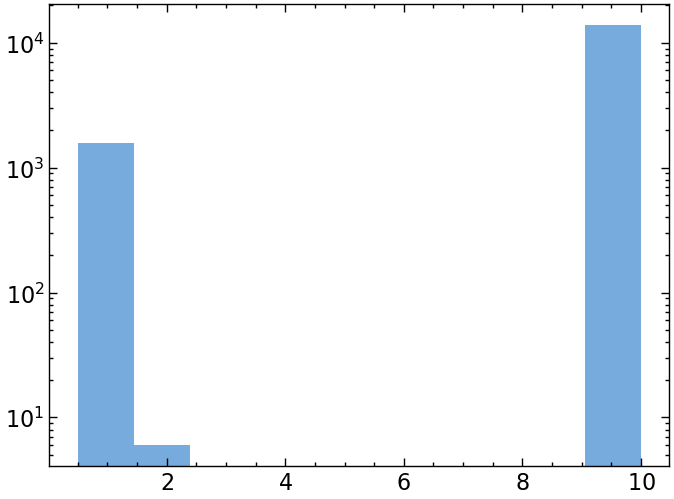

In [29]:
plt.hist(data_50Mpc['r_match'], log=True)

15398


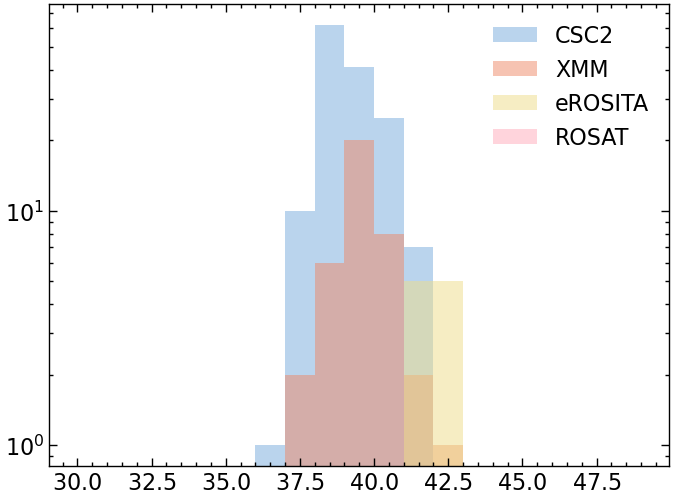

In [30]:
#plt.hist(data_50Mpc['_log_lx'][data_50Mpc['_log_lx_err']>0], log=True, bins=np.arange(30, 50, 1), alpha=.5, label='all',)
plt.hist(data_50Mpc['log_lx_csc'][data_50Mpc['log_lx_err_csc']>0], log=True, bins=np.arange(30, 50, 1), alpha=.5, label='CSC2')
plt.hist(data_50Mpc['log_lx_xmm'][data_50Mpc['log_lx_err_xmm']>0], log=True, bins=np.arange(30, 50, 1), alpha=.5, label='XMM')
plt.hist(data_50Mpc['log_lx_erosita'][data_50Mpc['log_lx_err_erosita']>0], log=True, bins=np.arange(30, 50, 1), alpha=.5, label='eROSITA')
plt.hist(data_50Mpc['log_lx_rosat'][data_50Mpc['log_lx_err_rosat']>0], log=True, bins=np.arange(30, 50, 1), alpha=.5, label='ROSAT')

plt.legend()

print(len(data_50Mpc['_log_lx'][data_50Mpc['_log_lx']>0]))

### Remove high-z interlopers

In [31]:
result_table = Vizier(catalog="V/154/sdss16", timeout=400).query_region(cat_50Mpc, radius=0.5*u.arcsec)
result_table[0]

<Table length=22434>
  _q         objID         RA_ICRS   ...      Sp-ID      _tab1_130 
                             deg     ...                     d     
int32        int64         float64   ...      str16       float64  
----- ------------------- ---------- ... --------------- ----------
    1 1237646011629174917  20.984799 ...                 51081.3415
    1 1237646011629174918  20.984798 ...                 51081.3415
    1 1237646505539600533  20.984801 ...                 51132.2024
    1 1237646505539600534  20.984787 ...                 51132.2024
    1 1237646505539600535  20.984787 ...                 51132.2024
    1 1237646647275159646  20.984780 ...                 51136.1918
    1 1237656512815825014  20.984787 ...                 52170.3789
    1 1237656512815825015  20.984775 ...                 52170.3789
    1 1237656512815825016  20.984775 ...                 52170.3789
  ...                 ...        ... ...             ...        ...
15413 1237658634527899747 190.537836 ...                 52356.4405
15413 1237661817096306707 190.537851 ...                 52721.2357
15413 1237661817096306708 190.537839 ...                 52721.2357
15413 1237661817096306709 190.537839 ... 1694-53472-0390 52721.2357
15416 1237668657917001760 274.810881 ...                 53528.4143
15416 1237668657917001799 274.810880 ...                 53528.4143
15417 1237666229123678469 303.809889 ...                 53264.2488
15418 1237663229076242654 327.825354 ...                 52909.1514
15422 1237661068189302894 184.563966 ...                 52667.4941
15424 1237679434525638878  16.481875 ...                 54847.1294

In [32]:
# Remove sources with redshift > 0.012 (~51 Mpc)

mask_zsp = np.isfinite(result_table[0]['zsp'].data.data)
cat_result = SkyCoord(result_table[0]['RA_ICRS'][mask_zsp], result_table[0]['DE_ICRS'][mask_zsp])
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, 0.5*u.arcsec)

data_50Mpc['z_dr16'] = -1.0 # mJy
data_50Mpc['z_dr16'][idx_50Mpc] = result_table[0]['zsp'].data.data[mask_zsp][idx_result]

In [33]:
result_table = Vizier(catalog="J/MNRAS/474/3875/gamadr3", timeout=400).query_region(cat_50Mpc, radius=0.5*u.arcsec)
result_table[0]

<Table length=224>
  _q        spectID       Survey ...  CataId           GAMA            Dist 
                                 ...                                  arcsec
int32        str33         str9  ...  int32           str23          float32
----- ------------------- ------ ... ------- ----------------------- -------
 2560  6dFg0214095-064823  6dFGS ... 2138298 GAMAJ021409.47-064822.6    0.29
 2615  320975784472766464   SDSS ...   70114 GAMAJ115412.26+000811.8    0.15
 2615  320977163341817856   SDSS ...   70114 GAMAJ115412.26+000811.8    0.15
 2615           2dF298044 2dFGRS ...   70114 GAMAJ115412.26+000811.8    0.49
 2645  340044064088942592   SDSS ...  496943 GAMAJ140843.28-010941.8    0.14
 2645  340044889930622976   SDSS ...  496943 GAMAJ140843.28-010941.8    0.14
 2645 1031416713540823040   SDSS ...  496943 GAMAJ140843.28-010941.8    0.10
 3439  749860644005636096   SDSS ... 2255550 GAMAJ020434.83-100630.1    0.37
 3450  6dFg0221365-053117  6dFGS ... 2521524 GAMAJ022136.47-053116.4    0.54
  ...                 ...    ... ...     ...                     ...     ...
14238  320974959839045632   SDSS ...   22741 GAMAJ115536.94+011413.8    0.30
14259      G12_Y1_EN1_052   GAMA ...  584731 GAMAJ120047.69-000123.9    0.15
14299           2dF294817 2dFGRS ...  220687 GAMAJ121119.91+012932.1    0.62
14336  584419605523490816   SDSS ...  221194 GAMAJ122027.66+012811.0    0.20
14337      G12_Y6_053_302   GAMA ...    9163 GAMAJ122033.75+004717.0    0.04
14631  601269891298781184   SDSS ...  238952 GAMAJ142327.11+014334.6    0.06
14649  343414342055651328   SDSS ...  593645 GAMAJ142934.59-000105.6    0.18
14672           2dF332170 2dFGRS ...  486594 GAMAJ144144.36-014825.2    0.91
14673      G15_Y1_GN1_051   GAMA ...   16828 GAMAJ144148.68+004113.0    0.14
14673  345816226045388800   SDSS ...   16828 GAMAJ144148.68+004113.0    0.09

In [34]:
# Remove sources with redshift > 0.012 (~51 Mpc)

mask_zsp = np.isfinite(result_table[0]['z'].data.data) & (result_table[0]['Prob'] > 0.0)
cat_result = SkyCoord(result_table[0]['RAJ2000'][mask_zsp], result_table[0]['DEJ2000'][mask_zsp])
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, 0.5*u.arcsec)

data_50Mpc['z_gama'] = -1.0 # mJy
data_50Mpc['z_gama'][idx_50Mpc] = result_table[0]['z'].data.data[mask_zsp][idx_result]

In [35]:
# the flux density measurements are likely underestimated by an average of ~15%.
# Additionally the astrometry is typically only accurate to ~0.25"

result_table = Vizier(catalog="J/ApJS/255/30").query_region(cat_50Mpc, radius=2.5*u.arcsec)
result_table[0]

<Table length=733>
  _q  ...
      ...
int32 ...
----- ...
  141 ...
  149 ...
  209 ...
  209 ...
 2087 ...
 2095 ...
 2143 ...
 2153 ...
 2549 ...
  ... ...
29843 ...
29859 ...
29871 ...
29871 ...
29963 ...
30009 ...
30655 ...
30797 ...
30797 ...
30799 ...

In [36]:
mask_point = result_table[0]['DCMaj'] < 0.5

cat_result = SkyCoord(result_table[0]['RAJ2000'], result_table[0]['DEJ2000'])
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result[mask_point], 5*u.arcsec)

d = (data_50Mpc['bestdist']*u.Mpc).to(u.cm).value

data_50Mpc['Ftot'] = 2.1 # mJy
data_50Mpc['e_Ftot'] = -1.0 # mJy
data_50Mpc['Ftot'][idx_50Mpc] = result_table[0]['Ftot'][mask_point][idx_result]
data_50Mpc['e_Ftot'][idx_50Mpc] = result_table[0]['e_Ftot'][mask_point][idx_result]

data_50Mpc['log_l_vlass'] = np.log10(4*np.pi*data_50Mpc['Ftot']*d**2)
data_50Mpc['l_vlass_err'] = 4*np.pi*data_50Mpc['e_Ftot']*d**2 

/tmp/tmp.iv8uLkOQDf/ipykernel_506675/9378452.py:13: RuntimeWarning: divide by zero encountered in log10
  data_50Mpc['log_l_vlass'] = np.log10(4*np.pi*data_50Mpc['Ftot']*d**2)


### Estimate SFR (from IR+GALEX photometry)

In [37]:
result_table = Vizier(catalog="II/335/galex_ais", timeout=3200).query_region(cat_50Mpc, radius=1.5*u.arcsec)
result_table[0]

<Table length=4289>
  _q   RAJ2000    DEJ2000            Name          ...  Nexf     Fr        Nr   
         deg        deg                            ...          deg       deg   
int32  float64    float64           str22          ... int16  float64   float64 
----- ---------- ---------- ---------------------- ... ----- --------- ---------
    1  20.984840   0.208705 GALEX J012356.3+001231 ...     0  0.003873  0.003523
    9 144.643587   8.887482 GALEX J093834.4+085314 ...     0        --  0.006759
   11 146.911188   4.821743 GALEX J094738.6+044918 ...     0  0.004142  0.003098
   12 150.466086 -28.510018 GALEX J100151.8-283036 ...     0        --  0.003891
   13 155.288659 -32.861287 GALEX J102109.2-325140 ...     0  0.008448  0.008572
   14 155.337559 -21.607707 GALEX J102121.0-213627 ...     0  0.002635  0.002347
   18 158.327692 -15.773242 GALEX J103318.6-154623 ...     2        --  0.002024
   21 159.738852 -20.045009 GALEX J103857.3-200242 ...     0  0.004102  0.004644
   22 160.258878 -30.794358 GALEX J104102.1-304739 ...     0  0.002438  0.002169
  ...        ...        ...                    ... ...   ...       ...       ...
15363 221.389354  31.915261 GALEX J144533.4+315454 ...     0  0.006797  0.011919
15372 236.531976  59.170153 GALEX J154607.6+591012 ...     0  0.007187  0.006512
15374 243.828336  42.922893 GALEX J161518.8+425522 ...     0  0.006042  0.004891
15382 346.734759   5.961654 GALEX J230656.3+055741 ...     3  0.005403  0.011059
15385 348.003672  27.294815 GALEX J231200.8+271741 ...     0  0.004832  0.004394
15386 350.394200   8.976416 GALEX J232134.6+085835 ...     0  0.003774  0.004915
15390 355.653513  27.826835 GALEX J234236.8+274936 ...     0  0.002451  0.002594
15398   9.389432  -6.921988 GALEX J003733.4-065519 ...     0  0.004282  0.006182
15410 186.925283  12.088922 GALEX J122742.0+120520 ...     0        --  0.005452
15413 190.538059  12.596462 GALEX J124209.1+123547 ...     0        --  0.015743

In [38]:
cat_result = SkyCoord(result_table[0]['RAJ2000'], result_table[0]['DEJ2000'])
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, 1.5*u.arcsec)

data_50Mpc['NUV'] = -1.0
data_50Mpc['FUV'] = -1.0 # mJy
data_50Mpc['NUV'][idx_50Mpc] = result_table[0]['NUVmag'][idx_result]
data_50Mpc['FUV'][idx_50Mpc] = result_table[0]['FUVmag'][idx_result]

In [39]:
result_table = Vizier(catalog="II/328/allwise", timeout=3200).query_region(cat_50Mpc, radius=1.5*u.arcsec)
result_table[0]

<Table length=9448>
  _q        AllWISE         RAJ2000     DEJ2000   ...  e_pmDE  qph    d2M   _2M 
                              deg         deg     ... mas / yr       arcsec     
int32        str19          float64     float64   ...  int32   str4 float32 str2
----- ------------------- ----------- ----------- ... -------- ---- ------- ----
    1 J012356.34+001230.8  20.9847811   0.2085807 ...      129 AABB      --   2M
    3 J055342.92-320544.9  88.4288586 -32.0958166 ...       90 AAAC   0.899   2M
    4 J060944.63-325001.4  92.4359878 -32.8337423 ...       67 AAAB   0.560   2M
    6 J082416.60+271056.8 126.0692033  27.1824507 ...      138 AAUU   0.073   2M
    7 J093434.08+130020.5 143.6420382  13.0057024 ...      148 AABU   0.177   2M
    9 J093834.46+085316.5 144.6436021   8.8879431 ...       49 AAAB   0.251   2M
   10 J094458.92+082211.6 146.2455214   8.3698967 ...      153 AABU   0.282   2M
   12 J100151.82-283037.2 150.4659410 -28.5103532 ...       81 AAAC   0.047   2M
   13 J102109.30-325139.1 155.2887613 -32.8608693 ...      161 AABB   0.856   2M
  ...                 ...         ...         ... ...      ...  ...     ...  ...
15401 J112927.52+541034.5 172.3646684  54.1762534 ...      370 ABUU      --   2M
15402 J113740.87-034214.5 174.4203093  -3.7040331 ...      470 ABCU      --   2M
15408 J122550.53+131151.0 186.4605626  13.1975251 ...      213 AAUU      --   2M
15410 J122742.09+120520.8 186.9253929  12.0891140 ...      140 AAUU      --   2M
15411 J122843.29+114518.1 187.1804001  11.7550547 ...       43 AAAC   0.271   2M
15413 J124209.09+123548.7 190.5378886  12.5968750 ...       64 AACU   0.479   2M
15415 J175211.55+243101.9 268.0481383  24.5172170 ...       93 AAAB   1.554   2M
15416 J181914.61+125504.9 274.8108974  12.9180431 ...       46 AAAC   0.079   2M
15417 J201514.38+090720.8 303.8099569   9.1224561 ...       61 AAAB   0.145   2M
15418 J215118.07+711319.9 327.8252989  71.2222069 ...       24 AAAA   0.227   2M

In [40]:
# https://wise2.ipac.caltech.edu/docs/release/allsky/expsup/sec4_4h.html

cat_result = SkyCoord(result_table[0]['RAJ2000'], result_table[0]['DEJ2000'])
idx_result, idx_50Mpc, d2d, d3d = cat_50Mpc.search_around_sky(cat_result, 5*u.arcsec)

data_50Mpc['W4mag'] = -1.0
data_50Mpc['W4mag'][idx_50Mpc] = result_table[0]['W4mag'][idx_result]

In [41]:
data_50Mpc.write('50Mpc_all.txt', format='csv', overwrite=True)

In [42]:
f_FUV = 1.40*1e-15 * 10**((data_50Mpc['FUV'] - 18.82)/-2.5)
f_IR = 8.363 * 10**(-data_50Mpc['W4mag']/2.5)

d = (data_50Mpc['bestdist']*u.Mpc).to(u.cm).value

L_FUV = np.full_like(f_FUV, -1.0)
L_IR = np.full_like(f_IR, -1.0)

L_FUV[data_50Mpc['FUV']>0] = (f_FUV*4*np.pi*d**2)[data_50Mpc['FUV']>0]
L_IR[data_50Mpc['W4mag']>0] = (f_IR*4*np.pi*d**2)[data_50Mpc['W4mag']>0]

L_FUV = (L_FUV*u.erg/u.s/u.AA).to(u.erg/u.s, equivalencies=u.spectral_density(0.15*u.um))
L_IR = (L_IR*u.Jy*u.cm**2).to(u.erg/u.s, equivalencies=u.spectral_density(22*u.um))

L_FUV_corr = L_FUV + 3.89 * L_IR
data_50Mpc['logSFR'] = 0.873*data_50Mpc['logmass'] - 8.99 # https://iopscience.iop.org/article/10.3847/1538-4357/aa9790/pdf
data_50Mpc['logSFR'][L_FUV_corr>0] = np.log10(L_FUV_corr.value[L_FUV_corr>0]) - 43.35

#data_50Mpc['logSFR'] = 1*(data_50Mpc['logmass']-10.2) # Popesso
#data_50Mpc['logSFR'][L_IR>0] = np.log10(gamma * 9.8*1e-11*L_IR.value[L_IR>0])
data_50Mpc['logSFRerr'] = np.sqrt(0.3**2 + 0.3**2) # Large errors to start
# https://iopscience.iop.org/article/10.3847/1538-4357/aa9790/pdf
data_50Mpc['logSFRerr'][L_FUV_corr>0] = 0.3 # Large errors to start
#data_50Mpc['logSFRerr'][~np.isfinite(data_50Mpc['SFR'])] = np.full(len(L_IR), 0.13)[~np.isfinite(data_50Mpc['SFR'])]

In [43]:
data_50Mpc

<Table length=15424>
        objname           pgc   ...        logSFR           logSFRerr     
         str29           int32  ...       float64            float64      
----------------------- ------- ... ------------------- ------------------
 2MASXJ01235631+0012308 3519080 ...   -1.77719279762443                0.3
 2MASXJ04575930-0612323 3689848 ...                 nan 0.4242640687119285
 2MASXJ05534289-3205449 3704923 ...  -1.909199411758955                0.3
 2MASXJ06094464-3250007 3707868 ... -2.1517239097419107                0.3
 2MASXJ07415401+2352188 3723606 ... -1.3887889999999992 0.4242640687119285
 2MASXJ08241658+2710571 3729986 ...  -2.821618819018674                0.3
 2MASXJ09343407+1300201 3743904 ... -1.5011339351481965                0.3
 2MASXJ09370295+6609161 3744472 ... -0.8667350000000003 0.4242640687119285
 2MASXJ09383447+0853159 3531206 ... -1.5832724121437778                0.3
 2MASXJ09445892+0822116 3460270 ... -2.0954674207271466                0.3
                    ...     ... ...                 ...                ...
SDSSJ175211.29+243059.0      -1 ... -1.4388090739207797                0.3
SDSSJ181914.60+125504.9      -1 ... -1.9421554194043935                0.3
SDSSJ201514.41+090721.2      -1 ... -1.4302360190565082                0.3
SDSSJ215118.06+711320.1      -1 ... -0.8664136679094057                0.3
SDSSJ012102.70+260517.0      -1 ...           -2.386628 0.4242640687119285
SDSSJ023330.49+270105.9      -1 ... -2.1971870000000004 0.4242640687119285
SDSSJ024055.00+263957.9      -1 ... -2.2355990000000006 0.4242640687119285
SDSSJ121814.50+134445.9      -1 ... -1.9579850000000008 0.4242640687119285
SDSSJ133850.79+080637.9      -1 ...           -2.659877 0.4242640687119285
SDSSJ010555.45-025135.9      -1 ... -2.0985380000000005 0.4242640687119285

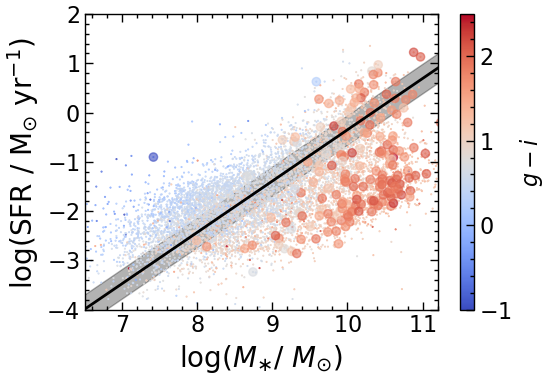

In [44]:
fig, ax = plt.subplots(1, 1, figsize=(5.7, 4.0))

x_eval = np.linspace(6, 12.5)
SFR_eval = -10.75 + 1.04*x_eval
plt.plot(x_eval, SFR_eval, color='k')
ax.fill_between(x_eval, SFR_eval+0.3, SFR_eval-0.3, alpha=0.3, color='k', zorder=-1)

mask = L_FUV_corr > 0
c = np.clip(data_50Mpc['gi_color'][mask], -1, 2.5)
im = ax.scatter(data_50Mpc['logmass'][mask], data_50Mpc['logSFR'][mask], marker='.', s=1, c=c, cmap='coolwarm')

mask_x = (data_50Mpc['_log_lx'] > 0) & (data_50Mpc['_log_lx_err']>0)
c = np.clip(data_50Mpc['gi_color'][mask & mask_x], -1, 2.5)
_ = ax.scatter(data_50Mpc['logmass'][mask & mask_x], data_50Mpc['logSFR'][mask & mask_x],
               marker='o', c=c, alpha=0.6, cmap='coolwarm', zorder=1)

#ax.scatter(data_50Mpc['logmass'][~mask], data_50Mpc['logSFR'][~mask], zorder=-1)

axc = fig.colorbar(im, ax=ax, cmap='RdBu')
axc.set_label(r'$g-i$')

ax.set_xlim(6.5, 11.2)
ax.set_ylim(-4, 2)

ax.set_ylabel(r'$\log( \rm{SFR}\ /\ M_{\odot}\ {\rm{yr}}^{-1} )$ ', fontsize=20)
ax.set_xlabel(r'$\log( M_{\ast} /\ M_{\odot})$', fontsize=20)

#ax.legend(fontsize=12, frameon=True)

fig.tight_layout()
fig.savefig('SFRMS.pdf', dpi=300)

## Completeness 

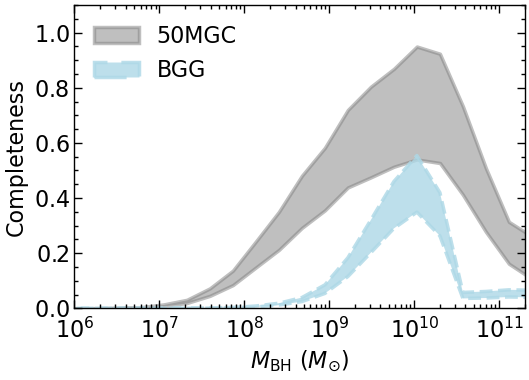

In [45]:
Ms = 10**10.745
phi1 = 10**-2.437
phi2 = 10**-3.201
alpha1 = -0.466
alpha2 = -1.530

_M = np.logspace(5, 11.5, 25)
dM = np.diff(_M)
M = _M[:-1] + dM/2
phidM = np.exp(-M/Ms)*(phi1*(M/Ms)**alpha1 + phi2*(M/Ms)**alpha2) * dM/Ms
#plt.loglog(M, phidM/np.diff(np.log10(_M)))
#plt.ylim(1e-5, 1e0)

# Draw from the GSMF
def inv_transform_sampling(y, x, n_samples=1000):
    """
    Perform inverse transform sampling on curve y(x)
    https://tmramalho.github.io/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/
    https://en.wikipedia.org/wiki/Inverse_transform_sampling
    """
    dx = np.diff(x)
    cum_values = np.zeros(x.shape)
    cum_values[1:] = np.cumsum(y*dx)/np.sum(y*dx)
    r = np.random.rand(int(n_samples))
    return np.interp(r, cum_values, x)

# Plot

#fig, ax0 = plt.subplots(1, 1, figsize=(6, 4.5))
fig, ax1 = plt.subplots(1, 1, figsize=(5.5, 4.0))

# X-ray
V = 4/3*np.pi*(50)**3
N_draw = int(V*np.trapz(phidM))
completeness_50MGC = np.zeros([len(_M)-1, 30])
for i in range(25):
    M_star = inv_transform_sampling(phidM/dM, _M, N_draw)

    h, bin_edges = np.histogram(M_star, bins=_M)
    #ax0.loglog(M, h, color='r', lw=2.5, label='model GSMF')

    # Exlude |b| < 30 deg
    mask_b = np.abs(cat_50Mpc.transform_to('galactic').b) > 10*u.deg

    # Exlude Virgo and Fornax
    mask_virgo = cat_50Mpc.separation(SkyCoord.from_name('Virgo Cluster')) > 12*u.deg
    mask_fornax = cat_50Mpc.separation(SkyCoord.from_name('Fornax Cluster')) > 1*u.deg

    mask = mask_b & mask_virgo & mask_fornax & (data_50Mpc['z_dr16'] < 0.012) & (data_50Mpc['z_gama'] < 0.012) #& (data_50Mpc['_log_lx'] > 0)
    h, bin_edges = np.histogram(10**data_50Mpc['logmass'][mask], bins=_M)
    #ax0.loglog(M, h, color='r', linestyle='dashed', lw=2.5, label='50MGC')

    # Completeness
    hist_model, bin_edges = np.histogram(M_star, bins=_M)
    hist, bin_edges = np.histogram(10**data_50Mpc['logmass'][mask], bins=_M)
    completeness_50MGC[:,i] = hist/hist_model
    completeness_50MGC[~np.isfinite(hist/hist_model),i] = 10
    #ax1.semilogx(M, completeness_50MGC, color='r', label='50MGC', linestyle='dashed', lw=2.5)

ax1.fill_between(M, np.percentile(completeness_50MGC, 16, axis=1), np.percentile(completeness_50MGC, 84, axis=1),
                color='gray', label='50MGC', linestyle='solid', lw=2.5, alpha=0.5)

# AMUSE
V = 4/3*np.pi*(30)**3
N_draw = int(V*np.trapz(phidM))
completeness_30MGC = np.zeros([len(_M)-1, 30])
for i in range(25):
    M_star = inv_transform_sampling(phidM/dM, _M, N_draw)

    h, bin_edges = np.histogram(M_star, bins=_M)
    #ax0.loglog(M, h, color='r', lw=2.5, label='model GSMF')

    # Completeness
    mask = mask_b & mask_virgo & mask_fornax & (data_50Mpc['z_dr16'] < 0.12) & (data_50Mpc['z_gama'] < 0.12) & (data_50Mpc['bestdist'] < 30)
    h, bin_edges = np.histogram(10**data_50Mpc['logmass'][mask], bins=_M)
    #ax0.loglog(M, h, color='r', linestyle='dashed', lw=2.5, label='30MGC')

    hist, bin_edges = np.histogram(10**data_50Mpc['logmass'][mask], bins=_M)
    completeness_30MGC[:,i] = hist/hist_model
    completeness_30MGC[~np.isfinite(hist/hist_model),i] = 10
    #ax1.plot(M, completeness_30MGC, color='gray', label='30MGC', linestyle='dashed', lw=2.5)

#ax1.fill_between(M, np.percentile(completeness_30MGC, 16, axis=1), np.percentile(completeness_30MGC, 84, axis=1),
#                 color='gray', label='30MGC', linestyle='solid', lw=2.5, alpha=0.5)


##########################

import pandas as pd
data_bgg = pd.read_excel('NSAVariability_wmasses_101319.xlsx')
data_bgg = Table.from_pandas(data_bgg)
data_bgg['nsaid'] = np.array([s[3:] for s in data_bgg['ObjID']], dtype=int)
cat_bgg = SkyCoord(data_bgg['RA'], data_bgg['Dec'], unit=u.deg)

# Variability
omega = (9380*u.deg**2).to(u.sr)
V = (cosmo.comoving_volume(0.055)*omega/(4*np.pi)).value
N_draw = int(V*np.trapz(phidM))
completeness_BGG = np.zeros([len(_M)-1, 30])
for i in range(25):
    M_star = inv_transform_sampling(phidM/dM, _M, N_draw)
    # Add some scatter
    M_star = 10**(np.log10(M_star) + np.random.normal(0, 0.3, len(M_star)))

    hist_model, bin_edges = np.histogram(M_star, bins=_M)
    #ax0.loglog(M, hist_model, color='b', lw=2.5, label='model GSMF')

    stellar_mass = data_bgg['Mstar']
    hist, bin_edges = np.histogram(stellar_mass, bins=_M)

    #ax0.loglog(M, hist, color='b', linestyle='dotted', lw=2.5, label='BGG')

    hist_model, bin_edges = np.histogram(M_star, bins=_M)
    completeness_BGG[:,i] = hist/hist_model
    completeness_BGG[~np.isfinite(hist/hist_model),i] = 10
    #ax1.semilogx(M, completeness_BGG, color='b', label='BGG', linestyle='dashed', lw=2.5)

ax1.fill_between(M, np.percentile(completeness_BGG, 16, axis=1), np.percentile(completeness_BGG, 84, axis=1),
                color='lightblue', label='BGG', linestyle='dashed', lw=2.5, alpha=0.8)

#####


ax1.set_xlim(1e6, 2e11)
ax1.set_ylim(0, 1.1)

ax1.set_xscale('log')


ax1.set_xlabel(r'$M_{\rm{BH}}$ ($M_{\odot}$)')
ax1.set_ylabel(r'Completeness')
ax1.legend(fontsize=16)

# Axis
locmaj = matplotlib.ticker.LogLocator(base=10,numticks=14) 
ax1.xaxis.set_major_locator(locmaj)
locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=14)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

ax1.tick_params(axis='x', which='major', pad=7)


fig.tight_layout()
fig.savefig('completeness.pdf', dpi=300)

## Prepare inputs

In [46]:
dat_miller = ascii.read('miller15.txt', format='csv', delimiter='\t', names=['name', 'V/F', 'dist', 'method', 'logmstar', 'loglx', 'sample'])
dat_miller
coord_miller = concatenate([SkyCoord.from_name(s) for s in dat_miller['name']])

# Match to Miller
idx_result, idx_50Mpc, d2d, d3d = coord_miller.search_around_sky(cat_50Mpc, 20*u.arcsec)
print(len(coord_miller), len(idx_result))

197 195


In [47]:
os.environ["OMP_NUM_THREADS"] = "1"

#from multiprocessing import Pool
from multiprocess import Pool

from multiprocessing import cpu_count
ncpu = cpu_count() - 1
print("{0} CPUs".format(ncpu))

47 CPUs


In [48]:
dataset = 'field'
#dataset = 'M15'
#dataset = 'virgo'

[1. 1. 1. ... 1. 1. 1.]


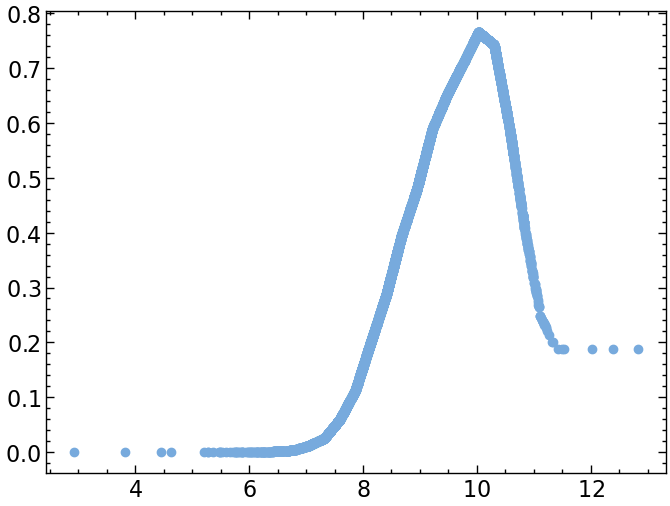

In [49]:
nsamp=1500 # 2000
nburn=800 # 600

if dataset == 'M15':

    dat_amuse = ascii.read('miller15.txt', guess=False, format='csv', delimiter='\t')
    dat_amuse

    dat_amuse = dat_amuse[dat_amuse['note']=='Clean'] # clean sample
    # Remove sources

    # Read the table, if the luminosity is an upper limit, add a flag
    dat_amuse['flag_lim'] = 0
    for i, Lxi in enumerate(dat_amuse['logLx']):
        if '<' in Lxi:
            dat_amuse['logLx'][i] = Lxi[1:]
            dat_amuse['flag_lim'][i] = 1
    dat_amuse['logLx'] = np.array(dat_amuse['logLx'].data, dtype=float)

    x = dat_amuse['logMs'].data
    y = dat_amuse['logLx'].data


    # remove the outliers < 1e9

    xerr = np.full_like(y, 0.2)
    yerr = np.full_like(y, 0.1)
    yerr[dat_amuse['flag_lim']==1] = -1

    p_obs = np.clip(np.interp(x, np.log10(M), np.mean(completeness_50MGC, axis=1)), 1e-6, 1)

    logsfr = np.full_like(y, -20)
    logsfrerr = np.full_like(y, 0.1)

    # all early types
    n = np.full_like(y, 4.0)
    # Use size-mass relation
    d25 = 4 * 3.47*1e-5*(10**(x))**0.56 # 0.5 dex scatter
    d25 = d25 * cosmo.arcsec_per_kpc_proper(z_at_value(cosmo.comoving_distance, 15*u.Mpc)).value

    r_match = np.full(len(y), 0.5)

else:

    _y = data_50Mpc['_log_lx'].copy()
    _yerr = data_50Mpc['_log_lx_err'].copy()

    # sources with no observation should have an upper limit set by ROSAT or EROSITA
    # Use whichever limit is more constraining
    #yerr[y==-1] = -1.0

    _x = data_50Mpc['logmass'].copy()
    _xerr = np.sqrt((data_50Mpc['logmass_error'].copy())**2 + 0.3**2)

    ## TODO: ADD these quantities to the full table and use ROSAT flux limit for the non-detections

    # Exlude |b| < 30 deg
    mask_b = np.abs(cat_50Mpc.transform_to('galactic').b) > 10*u.deg

    if dataset == 'virgo':

        mask_virgo = (cat_50Mpc.separation(SkyCoord.from_name('Virgo Cluster')) < 12*u.deg) & (np.abs(data_50Mpc['bestdist'] - 16.5) < 3*data_50Mpc['bestdist_error'])  & (np.abs(data_50Mpc['bestdist'] - 16.5) < 8)

    else:

        # Exlude Virgo and Fornax
        mask_virgo = cat_50Mpc.separation(SkyCoord.from_name('Virgo Cluster')) > 12*u.deg
        
    mask_fornax = cat_50Mpc.separation(SkyCoord.from_name('Fornax Cluster')) > 1*u.deg

    mask = mask_b & mask_virgo & mask_fornax & np.isfinite(_x) & np.isfinite(_y) & np.isfinite(_xerr) & np.isfinite(_yerr) & \
        (data_50Mpc['z_dr16'] < 0.012) & (data_50Mpc['z_gama'] < 0.012) & (_y > 0) #& (data_50Mpc['bestdist_error']/data_50Mpc['bestdist'] < 1)
    x = _x[mask]
    y = _y[mask]
    xerr = _xerr[mask]
    yerr = _yerr[mask]
    logsfr = data_50Mpc['logSFR'].copy()[mask]
    logsfrerr = data_50Mpc['logSFRerr'].copy()[mask]
    dist = data_50Mpc['bestdist'].copy()[mask]
    colortype = data_50Mpc['best_type'].copy()[mask]
    d25 = data_50Mpc['d25'].copy()[mask]*60 # arcsec
    r_match = data_50Mpc['r_match'].copy()[mask]
    mask_nod25 = ~np.isfinite(d25)
    # 2 R50 = R100
    # 2 R100 = d
    # Start with size-mass relation
    d25[mask_nod25 & (colortype=='early')] = 4 * 3.47*1e-5*(10**(x[mask_nod25 & (colortype=='early')]))**0.56 # 0.5 dex scatter
    d25[mask_nod25 & (colortype=='late')] = 4 * 0.1*(10**(x[mask_nod25 & (colortype=='late')]))**0.14 * (1 + 10**(x[mask_nod25 & (colortype=='late')])/(3.98*1e10))**(0.39 - 0.14) # 0.5 dex scatter
    d25[mask_nod25] = d25[mask_nod25] * cosmo.arcsec_per_kpc_proper(z_at_value(cosmo.comoving_distance, dist[mask_nod25]*u.Mpc)).value
    # Start with average value for galaxies without best type
    n = np.full(len(x), 2.5)
    n[colortype=='early'] = 4.0
    n[colortype=='late'] = 1.0
    print(n)

    lvlass = data_50Mpc['Ftot'].copy()[mask]
    lvlass_e = data_50Mpc['e_Ftot'].copy()[mask]

    # 2-7 keV -> 2-10 keV
    Gamma = 1.8
    Lb = (10**(2-Gamma) - 2**(2-Gamma))/(7**(2-Gamma) - 2**(2-Gamma))
    y_27 = y

    y = np.log10(Lb*10**y_27)
    yerr = y/y_27*yerr

    if (dataset == 'virgo') or (dataset == 'M15'):

        p_obs = np.ones_like(x)

    else:

        p_obs = np.clip(np.interp(x, np.log10(M), np.mean(completeness_50MGC, axis=1)), 1e-6, 1)

    #p_obs = np.ones_like(x)

    plt.scatter(x, p_obs)

    # Save the input for multiwavelength analysis!
    tvar = Table([x, y, xerr, yerr, logsfr, logsfrerr, d25, n, p_obs, r_match], names=['x', 'y', 'xerr', 'yerr', 'logsfr', 'logsfrerr', 'd25', 'n', 'pobs', 'r_match'])
    tvar.write('tcsc.txt', overwrite=True, format='ascii')

## INFERENCE

color='C4'
ylims=[None, None]

### Likelihood

In [50]:
def log_likelihood(theta, x, y, xerr, yerr, logSFR, logSFRerr, d25, n, p_obs, r_match):

    # parameters to be fit
    log_ms0, delta1, ep, log_lam_min, log_lam_s, log_f, f_a, delta, theta2, P_XRB, c = theta
    
    mask_det = yerr > 0

    #x_bh = 7.43 + 1.61*(x - np.log10(3e10)) # 0.81
    x_bh = 6.70 + 1.61*(x - np.log10(3e10)) # Late-type (AGN)

    L_HX = 9.05*1e28 * 10**x + 1.62*1e39 * 10**logSFR
    L_gas = 8.3*1e38 * 10**logSFR
    b = 2*n - 1/3
    alpha = ((2*r_match)/d25)
    logL_SF = np.log10(L_HX + L_gas) + np.log10(gammainc(2*n, b*alpha**(1/n)) / gammainc(2*n, b))
    ## TEST
    
    BC = 1 # Bolometric correction
    log_lam = y + BC - 38.2 - x_bh #- logL_SF # residual
    lam = 10**log_lam
    lam_s = 10**log_lam_s

    if log_lam_min > np.min(log_lam[mask_det]):
        return -np.inf, np.zeros_like(y[mask_det]), np.zeros_like(y[mask_det])
    
    log_lam_max = np.max(log_lam[mask_det])

    dlog_lam = 0.1
    dlog_lam_int = 0.1
    log_lam_eval = np.arange(log_lam_min, log_lam_max + dlog_lam, dlog_lam)
    log_lam_int = np.arange(-6, log_lam_max + 2 + dlog_lam, dlog_lam_int) #
    lam_eval = 10**log_lam_eval
    lam_int = 10**log_lam_int
    dlam_eval = np.diff(lam_eval)
    dlam_int = np.diff(lam_int)
    
    s2 = np.full(len(mask_det), np.exp(2*log_f)**2 + (1.61*xerr)**2)
    s2[mask_det] = yerr[mask_det]**2 + np.exp(2*log_f)**2 + (1.61*xerr[mask_det])**2

    # Either the source is an XRB or a BH
    # Try making the scatter here a free parameter
    s2_XRB = np.full(len(mask_det), (0.4)**2 + xerr**2)
    s2_XRB[mask_det] = (0.4)**2 + (yerr[mask_det])**2 + (xerr[mask_det])**2 + (logSFRerr[mask_det])**2
    pdf_XRB = st.norm.pdf(y[mask_det] - logL_SF[mask_det], scale=np.sqrt(s2_XRB[mask_det]))
    #pdf_XRB = st.norm.pdf(y[mask_det] - logL_SF[mask_det], scale=np.sqrt(s2_XRB[mask_det]))

    # p = f * N + (1 - p) delta 
    _f_BHOF = f_x(x, log_ms0, f_a, delta, theta2)

    delta1 = delta1 + 1

    # Detections
    # pdf
    pdf_pl_int = ( (lam_int/lam_s)**delta1 + (lam_int/lam_s)**(delta1+ep) )**(-1)
    pdf_int = fftconvolve(pdf_pl_int, st.norm.pdf(np.arange(-5, 5, dlog_lam_int), loc=0, scale=np.sqrt(np.mean(s2[mask_det]))), mode='same') # np.sqrt(np.mean(s2[mask_det])))
    # at small values, the extrapolation gets wacky
    f = interp1d(log_lam_int, pdf_int, bounds_error=False, fill_value='extrapolate')
    # 
    def f_extrap(ll, l1=-5.5, l2=0.0):
        mask_pl = (ll > l1) & (ll < l2)
        # Get the lower & upper -slopes
        x1 = np.array([-5.5, -5.0, -4.5])
        x2 = np.array([-1.0, -0.5, 0.0])
        pl1 = interp1d(x1, np.log10(f(x1)), fill_value='extrapolate')
        pl2 = interp1d(x2, np.log10(f(x2)), fill_value='extrapolate')
        return np.concatenate([10**pl1(ll[ll <= l1]), f(ll[mask_pl]), 10**pl2(ll[ll >= l2])])

    # Trim
    pdf_eval = f_extrap(log_lam_eval)
    # Normalize
    C = 1/trapezoid(pdf_eval, dx=dlam_eval)
    pdf_eval = C * pdf_eval
    # Evaluate
    f = interp1d(log_lam_eval, pdf_eval)
    pdf = f(log_lam[mask_det])

    ### DEBUG ###
    #plt.loglog(lam_int, pdf_int)
    #plt.show()
    #plt.loglog(lam_int, C * pdf_pl_int)
    #plt.show()
    #plt.loglog(lam_eval, pdf_eval)
    #plt.show()
    #adsf
    ### DEBUG ###

    # Censored
    # cdf
    cdf_eval = cumulative_trapezoid(pdf_eval, dx=dlam_eval, initial=0)
    f = interp1d(log_lam_eval, cdf_eval, bounds_error=False, fill_value=(0.0, 1.0))
    cdf = f(log_lam[~mask_det])

    cdf_XRB = st.norm.cdf(y[~mask_det] - logL_SF[~mask_det], scale=np.sqrt(s2_XRB[~mask_det]))
    #cdf_XRB = st.norm.cdf(y[~mask_det] - logL_SF[~mask_det], scale=np.sqrt(s2_XRB[~mask_det]))
    #P_XRB = 0
    # Mixture model
    # https://dfm.io/posts/mixture-models/
    p_det = p_obs[mask_det] * ((1 - P_XRB) * _f_BHOF[mask_det] * pdf + P_XRB * pdf_XRB)
    p_cens = p_obs[~mask_det] * ((1 - P_XRB) * (_f_BHOF[~mask_det] * cdf + 1 - _f_BHOF[~mask_det]) + P_XRB * 1)

    # Total likelihood
    ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))

    ll_fg = np.log(p_obs[mask_det] * ((1 - P_XRB) * _f_BHOF[mask_det] * pdf))
    ll_bg = np.log(p_obs[mask_det] * P_XRB * pdf_XRB)
    
    return ll, ll_fg, ll_bg

In [51]:
#x_bh = 7.43 + 1.61*(x - np.log10(3e10)) # 0.81
x_bh = 6.70 + 1.61*(x - np.log10(3e10)) # Late-type (AGN)
BC = 1 # Bolometric correction
log_lam = y + BC - 38.2 - x_bh # residual

#  log_ms0, delta1,ep,log_lam_min,           log_lam_s, log_f,  f_a, delta, theta2, PSF, c = theta
pos = [9.0, 0.4, 2.5, np.min(log_lam[yerr > 0])-1, -2.0, -1.0,  0.05, 5,     4.0,   0.01, 0.01]

labels = ['log_ms0', 'delta1', 'ep', 'log_lam_min', 'log_lam_s', 'log_f', 'f_a', 'delta', 'theta2', 'P_SF', 'c']

pos = np.array(pos) + 1e-4 * np.random.randn(32, len(pos))
nwalkers, ndim = pos.shape

def log_prior(theta):
    log_ms0, delta1, ep, log_lam_min, log_lam_s, log_f, f_a, delta, theta2, P_SF, c = theta
    
    # Power-Law Priors
    if 5.0 < log_ms0 < 12.0 and 0.01 < delta1 < 2.0 and 0.0 < ep < 5.0 and -12.0 < log_lam_min < 0.0 and -8.0 < log_lam_s < 0.0 and -4.0 < log_f < 1.0 and 0 < f_a < 1 and 0.01 < delta < 50 and 1 < theta2 < 50 and 0 < P_SF < 1 and 0 < c < 6:
        return np.log(st.norm.pdf(delta1, 0.47, (0.42+0.20)/2)) + np.log(st.norm.pdf(ep, 2.22, (0.51+0.30)/2)) + np.log(st.norm.pdf(log_lam_s, -1.84, (0.37+0.30)/2))
    
    return -np.inf

# log probability global
args_global = (x, y, xerr, yerr, logsfr, logsfrerr, d25, n, p_obs, r_match)

def log_probability(theta):
    x, y, xerr, yerr, logSFR, logSFRerr, d25, n, p_obs, r_match = args_global
    lp = log_prior(theta)
    ll, ll_fg, ll_bg = log_likelihood(theta, x, y, xerr, yerr, logSFR, logSFRerr, d25, n, p_obs, r_match)
    if not np.isfinite(lp) or not np.isfinite(ll):
        return -np.inf, np.zeros_like(y[yerr>0]), np.zeros_like(y[yerr>0])
    return lp + ll, ll_fg, ll_bg

### Inference

In [52]:
ncpu = 1

if ncpu > 1:
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, pool=pool, moves=[
        (emcee.moves.DEMove(), 0.8),
        (emcee.moves.DESnookerMove(), 0.2),
    ],)
        sampler.run_mcmc(pos, nsamp, progress=True);
else:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, moves=[
        (emcee.moves.DEMove(), 0.8),
        (emcee.moves.DESnookerMove(), 0.2),
    ],)
    sampler.run_mcmc(pos, nsamp, progress=True);

  2%|▏         | 28/1500 [00:06<05:18,  4.62it/s]/tmp/tmp.iv8uLkOQDf/ipykernel_506675/2616034959.py:102: RuntimeWarning: invalid value encountered in log
  ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))
/tmp/tmp.iv8uLkOQDf/ipykernel_506675/2616034959.py:105: RuntimeWarning: invalid value encountered in log
  ll_bg = np.log(p_obs[mask_det] * P_XRB * pdf_XRB)
/tmp/tmp.iv8uLkOQDf/ipykernel_506675/2616034959.py:105: RuntimeWarning: invalid value encountered in log
  ll_bg = np.log(p_obs[mask_det] * P_XRB * pdf_XRB)
  2%|▏         | 29/1500 [00:06<05:18,  4.62it/s]/tmp/tmp.iv8uLkOQDf/ipykernel_506675/2616034959.py:105: RuntimeWarning: invalid value encountered in log
  ll_bg = np.log(p_obs[mask_det] * P_XRB * pdf_XRB)
  2%|▏         | 31/1500 [00:06<05:18,  4.61it/s]/tmp/tmp.iv8uLkOQDf/ipykernel_506675/2616034959.py:102: RuntimeWarning: invalid value encountered in log
  ll = np.sum(np.log(p_det)) + np.sum(np.log(p_cens))
/tmp/tmp.iv8uLkOQDf/ipykernel_506675/2616034959.py:105: RuntimeW

In [53]:
norm = 0.0
post_prob = np.zeros(len(x[yerr>0]))
for i in range(sampler.chain.shape[1]):
    for j in range(sampler.chain.shape[0]):
        ll_fg, ll_bg = sampler.blobs[i][j]
        post_prob += np.exp(ll_fg - np.logaddexp(ll_fg, ll_bg))
        norm += 1
post_prob /= norm

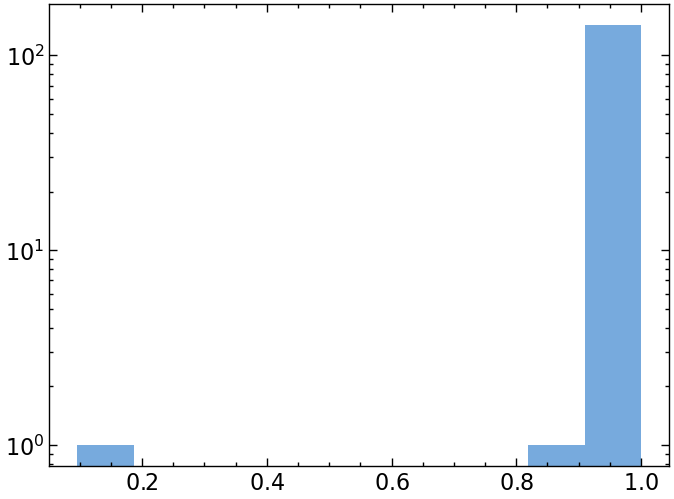

In [54]:
plt.hist(post_prob, log=True); # probability of being in an AGN

(array([87.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 58.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

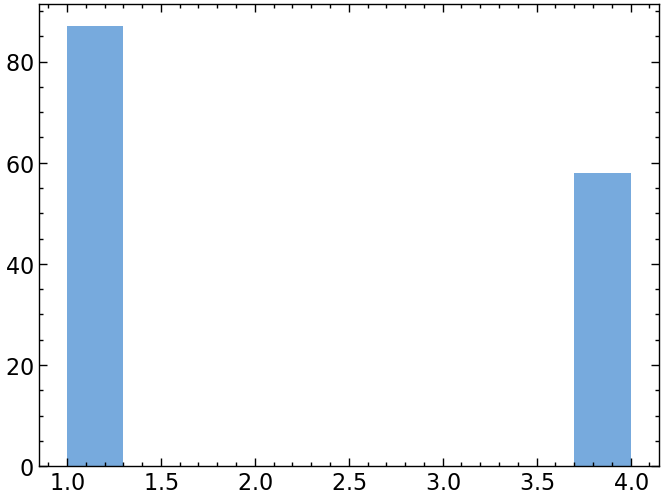

In [55]:
plt.hist(n[yerr>0]) #n = 1, spiral = late type galaxies

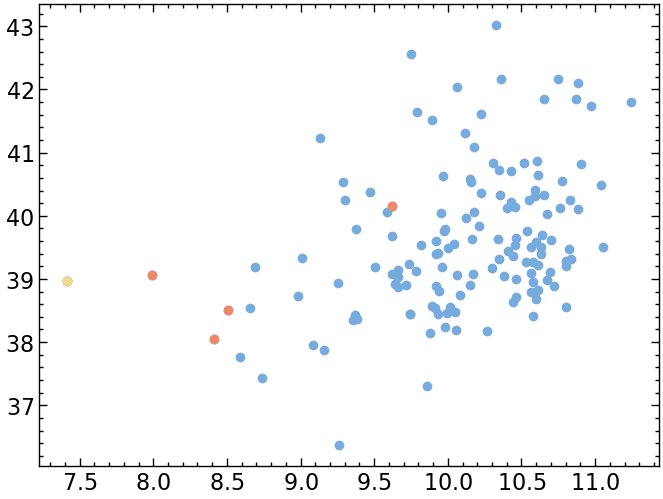

In [56]:
plt.scatter(x[yerr>0], y[yerr>0])
plt.scatter(x[yerr>0][post_prob<.999], y[yerr>0][post_prob<.999])
plt.scatter(x[yerr>0][post_prob<.5], y[yerr>0][post_prob<.5])


(4480, 11)
95% CI:  8.874305441024465
y lim 40


/tmp/tmp.iv8uLkOQDf/ipykernel_506675/1916941088.py:77: RuntimeWarning: overflow encountered in power
  foccs[i,:] = 1/(1 + s[7] * np.exp(-s[8]*(x_eval - s[0])))**(1/s[7])


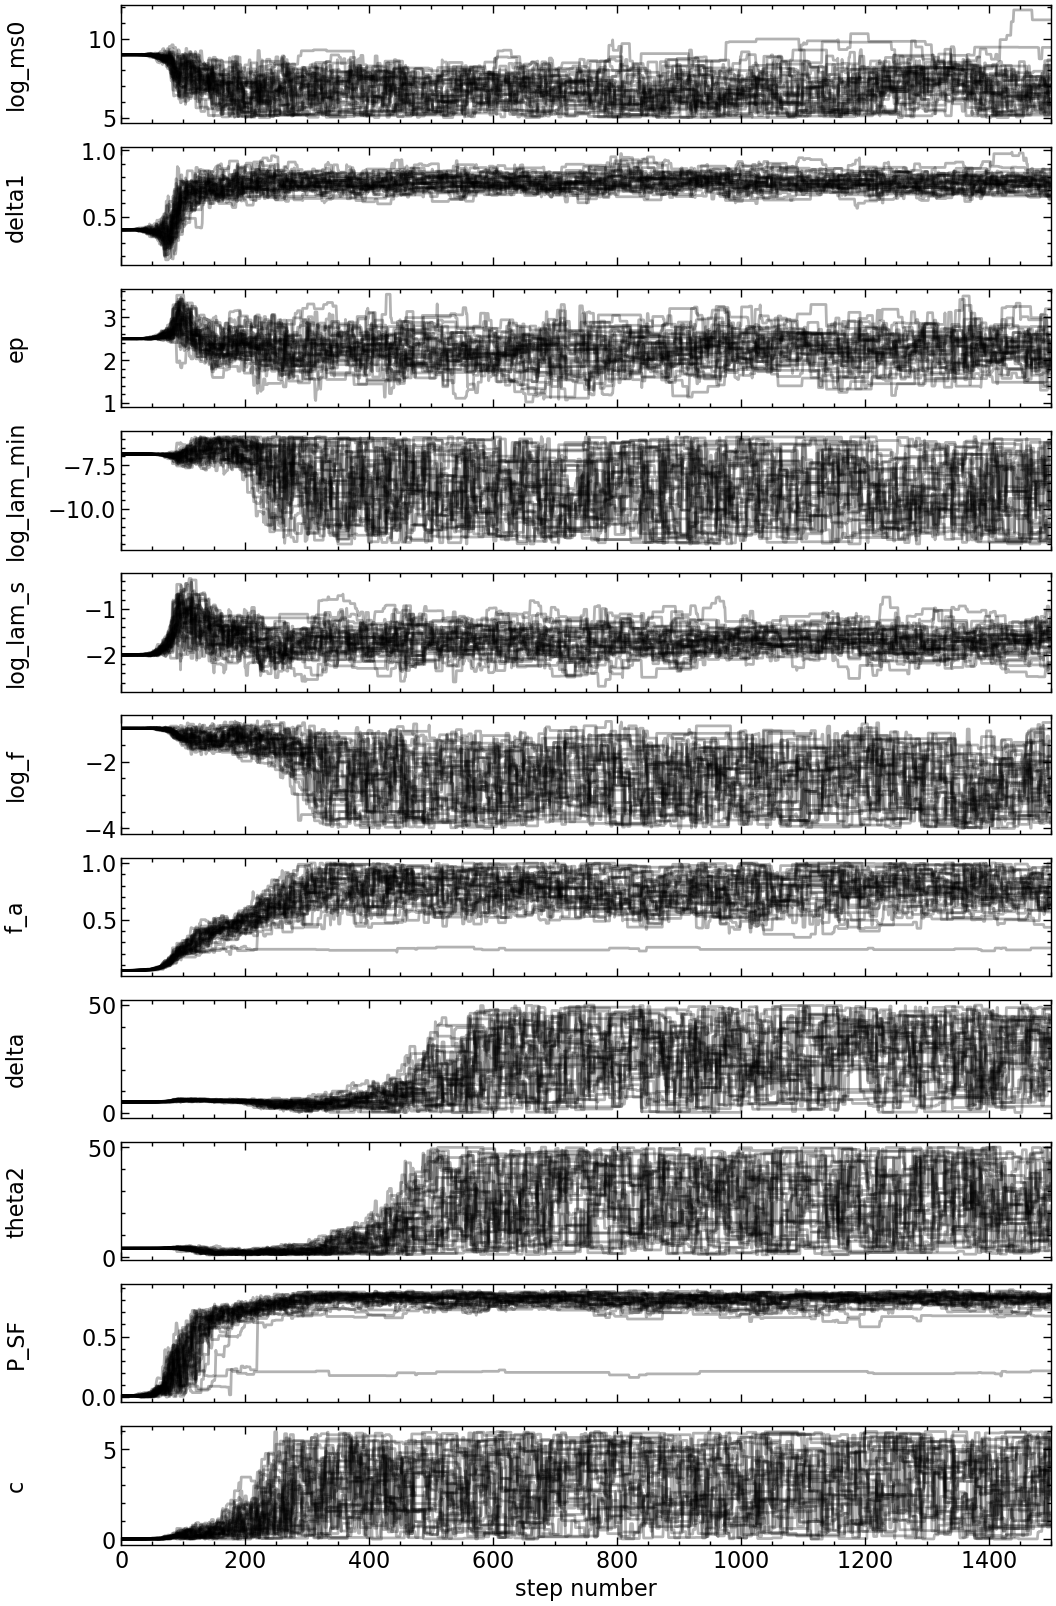

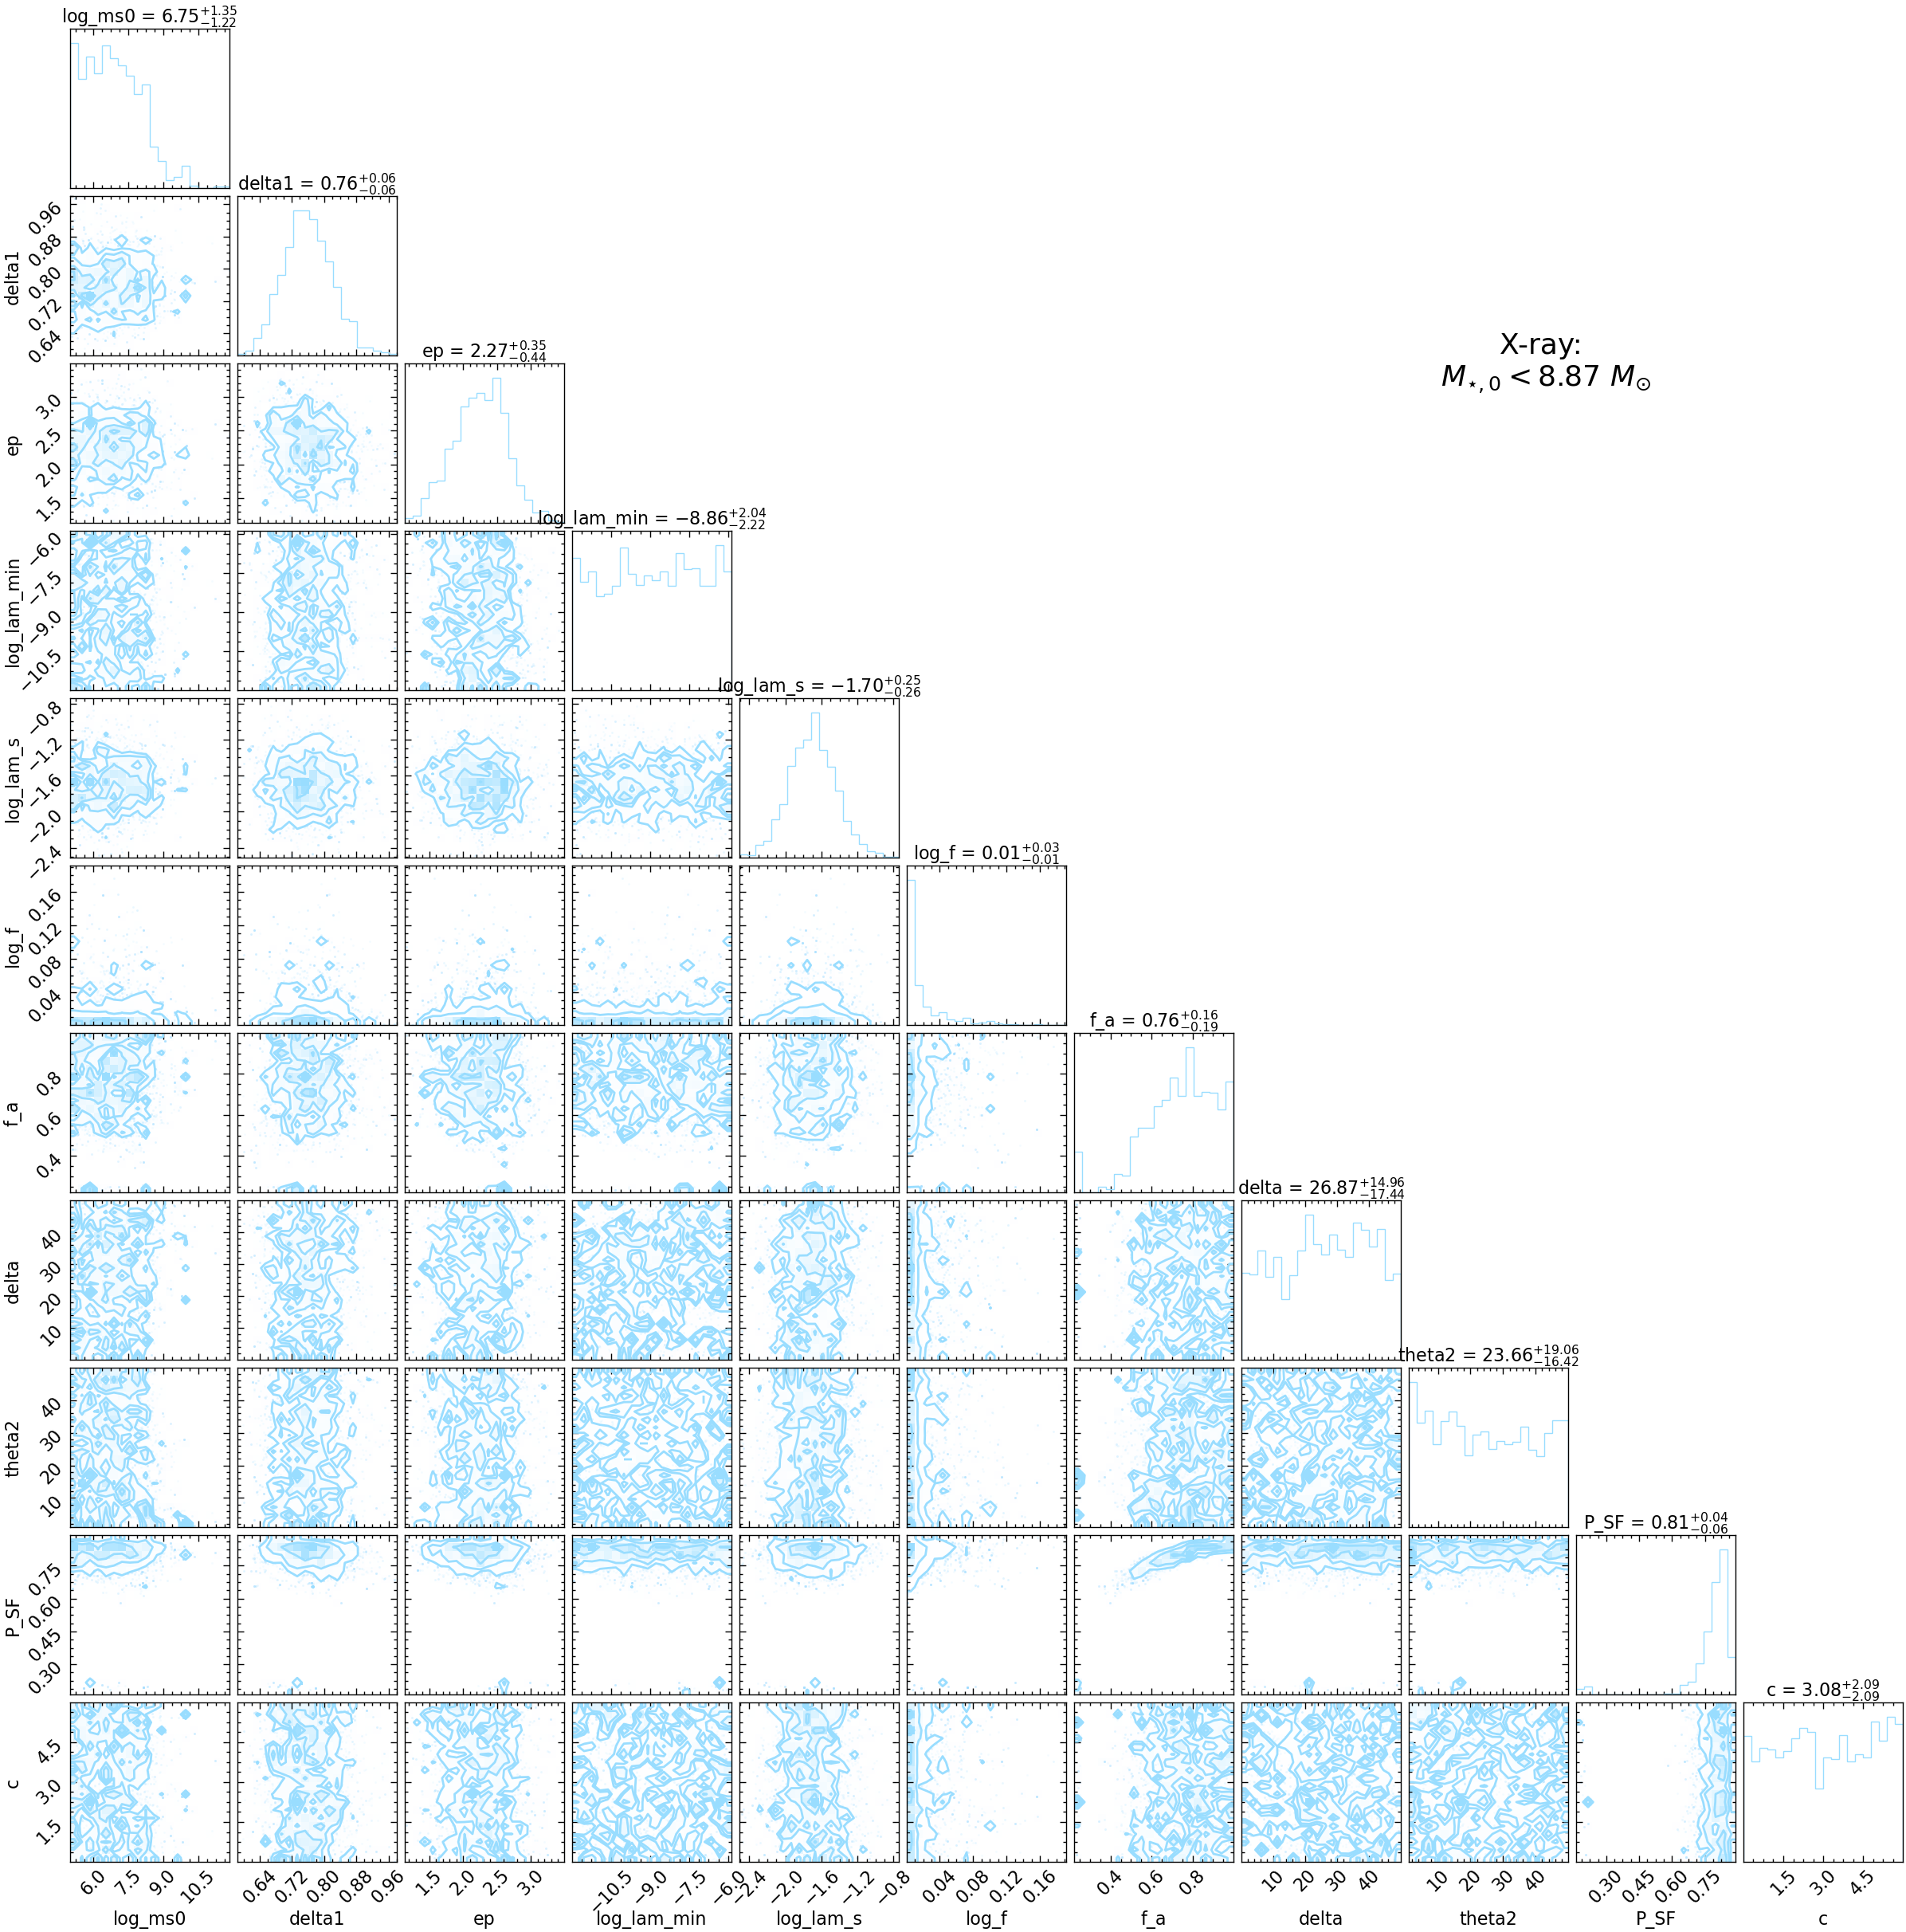

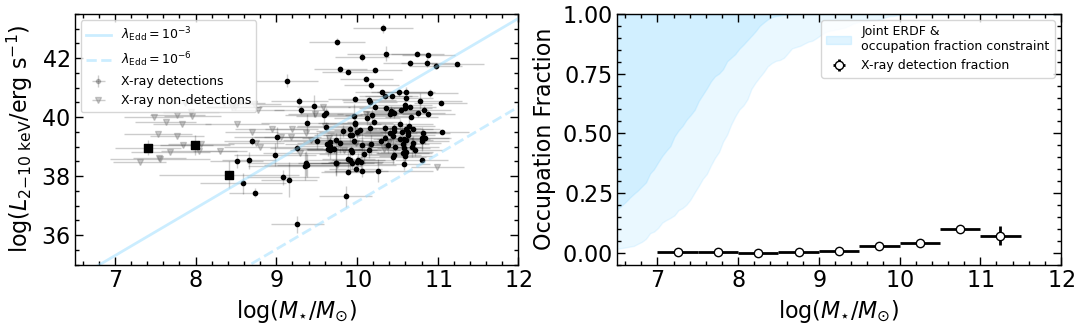

In [57]:
# Plot
fig, axes = plt.subplots(ndim, figsize=(12, 20), sharex=True)
samples = sampler.get_chain()
labels = ['log_ms0', 'delta1', 'ep', 'log_lam_min', 'log_lam_s', 'log_f', 'f_a', 'delta', 'theta2', 'P_SF', 'c']

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

#tau = sampler.get_autocorr_time()
#print(tau)

flat_samples = sampler.get_chain(discard=nburn, thin=5, flat=True)

#flat_samples_amuse = sampler_amuse.get_chain(discard=nburn, thin=5, flat=True)

print(flat_samples.shape)

flat_samples[:,5] = np.exp(2*flat_samples[:,5]) # sigma

# Medians
fig_corner = corner.corner(flat_samples, labels=labels, color=color, show_titles=True)

# TODO::::: Increase the 1st column limit + 1 and use 95th percentile

fig, axes = plt.subplots(1, 2, figsize=(11, 3.5))
#inds = np.random.randint(len(flat_samples), size=100)

# Plot data
x_eval = np.linspace(5, 15, 200)
axes[0].scatter(x[(yerr > 0)][(post_prob > .95)], y[(yerr > 0)][(post_prob > .95)], marker='.', color='k', alpha=1)
axes[0].errorbar(x[yerr > 0], y[yerr > 0], elinewidth=1,
                    xerr=xerr[yerr > 0], yerr=yerr[yerr > 0],
                    fmt=".k", capsize=0, alpha=0.2, label='X-ray detections')

axes[0].scatter(x[(yerr > 0)][(post_prob < .95)], y[(yerr > 0)][(post_prob < .95)], marker='s', color='k', alpha=1)
#axes[0].scatter(x[(yerr > 0) & (log_lam<-6)], y[(yerr > 0) & (log_lam<-6)], marker='s', color='k', alpha=1)

# Pick random
if len(y[yerr < 0]) > 50:
    #ind_rand = np.arange(len(y[yerr < 0]))
    ind_rand = np.random.choice(len(y[yerr < 0]), 50, replace=False)
else:
    ind_rand = np.arange(len(y[yerr < 0]))

axes[0].errorbar(x[yerr < 0][ind_rand], y[yerr < 0][ind_rand],
                    xerr=xerr[yerr < 0][ind_rand], elinewidth=1, markersize=5,
                    marker="v", linestyle="none", color="gray", alpha=0.4, capsize=0, zorder=-1, label='X-ray non-detections')
axes[0].legend(fontsize=14)
axes[0].set_xlim([6.5, 12])
axes[0].set_ylim([35, 43.5])
axes[0].set_xlabel(r'$\log(M_{\star} / M_{\odot})$')
axes[0].set_ylabel(r'$\log(L_{2{-}10\ {\rm{keV}}} / {\rm{erg}}\ {\rm{s}}^{-1})$')

# Linear relation
x_bh_eval = 6.70 + 1.61*(x_eval - np.log10(3e10)) # Late-type (AGN)
BC = 1 # Bolometric correction
y_eval = -BC + 38.2 + x_bh_eval

axes[0].plot(x_eval, y_eval-3, color=color, alpha=0.5, zorder=2, label=r'$\lambda_{\rm{Edd}} = 10^{-3}$')

axes[0].plot(x_eval, y_eval-6, color=color, alpha=0.5, zorder=2, linestyle='dashed', label=r'$\lambda_{\rm{Edd}} = 10^{-6}$')

# Limits
log_ms0_low = np.percentile(flat_samples[:,0], 95)
log_ms0_high = np.percentile(flat_samples[:,0], 5)
print('95% CI: ', log_ms0_low)

# Occupation fraction
foccs = np.zeros([len(flat_samples), len(x_eval)])
for i, s in enumerate(flat_samples):
    foccs[i,:] = 1/(1 + s[7] * np.exp(-s[8]*(x_eval - s[0])))**(1/s[7])
    #foccs[i,:] = 1/2*(1 + np.tanh(2.5**np.abs(8.9 - s[0]) * (x_eval - s[0])))

axes[1].fill_between(x_eval, np.percentile(foccs, 16, axis=0), np.percentile(foccs, 84, axis=0), color=color, alpha=0.3,
                        label=r'Joint ERDF &'+'\n'+'occupation fraction constraint')
axes[1].fill_between(x_eval, np.percentile(foccs, 5, axis=0), np.percentile(foccs, 95, axis=0), color=color, alpha=0.2)

if dataset == 'virgo':
    # Overplot the field results in gray

    flat_samples_field = np.load('flat_samples_xray.npy')

    # Occupation fraction
    foccs = np.zeros([len(flat_samples_field), len(x_eval)])
    for i, s in enumerate(flat_samples_field):
        foccs[i,:] = 1/(1 + s[8] * np.exp(-s[9]*(x_eval - s[0])))**(1/s[8])

    #axes[1].fill_between(x_eval, np.percentile(foccs, 16, axis=0),  np.percentile(foccs, 84, axis=0), color='gray', alpha=0.1,
    #                    label=r'field galaxies')


elif dataset == 'M15':
    axes[1].fill_between(x_eval, 0.5 + 0.5*np.tanh(2.5**np.abs(8.9 - 7.70) * (x_eval - 7.70)),
                     0.5 + 0.5*np.tanh(2.5**np.abs(8.9 - 9.18) * (x_eval - 9.18)), color='gray', alpha=0.1, label='M15')

# Histogram
hist_det, bin_edges = np.histogram(x[yerr>0], bins=np.arange(5, 12, 0.5))
hist_all, bin_edges = np.histogram(x,  bins=np.arange(5, 12, 0.5))
frac_det = hist_det/hist_all

bincenter = (bin_edges[:-1] + bin_edges[1:]) / 2

axes[1].errorbar(bincenter[hist_det>0], frac_det[hist_det>0], xerr=0.5/2,
                    yerr=st.binom.std(hist_all[hist_det>0], frac_det[hist_det>0])/hist_all[hist_det>0],
                    color="k", capsize=0, marker='o', mfc='w', linestyle='none', label='X-ray detection fraction')

# Expectation fraction
y_lim = 40 #np.percentile(y[(yerr<0)], 90)

delta1 = np.median(flat_samples[:,1])
ep = np.median(flat_samples[:,2])
log_lam_min = np.median(flat_samples[:,3])
lam_s = 10**np.median(flat_samples[:,4])

dlogl = 0.1
log_lam_eval = np.arange(log_lam_min, 1, dlogl)
lam_eval = 10**log_lam_eval
dlam_eval = np.diff(lam_eval)
print('y lim', y_lim)

log_lam_max = np.max(log_lam[yerr>0])

lam_C = 10**np.arange(log_lam_min, log_lam_max, dlogl)
pdf_pl = ( (lam_eval/lam_s)**delta1 + (lam_eval/lam_s)**(delta1+ep) )**(-1)
# Convolve
pdf_norm_int = st.norm.pdf(log_lam_eval[:, np.newaxis] - log_lam_eval, scale=0.3 +np.median(flat_samples[:,5]))
pdf = trapezoid(pdf_pl * pdf_norm_int, dx=dlam_eval, axis=1)
pdf = np.interp(lam_C, lam_eval, pdf)
pdf /= trapezoid(pdf, dx=np.diff(lam_C))

log_lam_lims = y_lim + BC - 38.2 - x_bh_eval

fexp = np.zeros_like(x_bh_eval)
for i, x_bhi in enumerate(x_bh_eval):
    lam_int = 10**np.arange(log_lam_lims[i], log_lam_max, dlogl)
    fexp[i] = .2*trapezoid(np.interp(lam_int, lam_C, pdf), dx=np.diff(lam_int)) #/ trapezoid(pdf, dx=np.diff(lam_C))

#axes[1].plot(x_eval, fexp, color=color, lw=1.5, linestyle='dashed', label=r'Expected detection fraction')

# Right panel
if dataset == 'M15':
    axes[0].set_xlim([6.5, 12.5])
    axes[1].set_xlim([6.5, 12.5])
    axes[0].set_ylim([37, 43.5])
else:
    axes[1].set_xlim([6.5, 12])
axes[1].set_ylim([-0.05, 1])
axes[1].set_xlabel(r"$\log(M_{\star} / M_{\odot})$")
axes[1].set_ylabel(r"Occupation Fraction")

axes[0].legend(loc='upper left', fontsize=9, frameon=True)
if dataset == 'virgo':
    axes[1].legend(loc='upper right', fontsize=9, frameon=True)
else:
    axes[1].legend(loc='upper right', fontsize=9, frameon=True)

fig_corner.text(.8, .8, 'X-ray: \n'+r'$M_{\star,0} < $'+f'{np.round(log_ms0_low,2)}'+r' $M_{\odot}$', ha='center', fontsize=26)

fig.tight_layout()

if dataset == 'virgo':
    fig.savefig('bhofxrayvirgo.pdf', dpi=300)
elif dataset == 'M15':
    fig.savefig('bhofxraymiller.pdf', dpi=300)
else:
    fig.savefig('bhofxray.pdf', dpi=300)

In [58]:
np.percentile(flat_samples, .999, axis=0)[6]

0.23621103752255232

In [59]:
#if dataset == 'field':
#    np.save('flat_samples_xray', flat_samples)

In [60]:
#if dataset == 'field':
#    flat_samples = np.load('flat_samples_xray.npy')

In [61]:
if dataset == 'field':

    mask = mask_b & mask_virgo & mask_fornax & np.isfinite(_x) & np.isfinite(_y) & np.isfinite(_xerr) & np.isfinite(_yerr) & \
        (data_50Mpc['z_dr16'] < 0.012) & (data_50Mpc['z_gama'] < 0.012) & (_y > 0)

    # Only include detections 

    cols = ['objname', 'ra', 'dec', 'bestdist', 'bestdist_error', 'logmass', 'logmass_error', '_log_lx', '_log_lx_err', 'logSFR', 'logSFRerr', 'best_type', 'p_SF']
    # Write to latex
    #data_50Mpc[mask][(y>0) & (yerr>0) & (x<8)]
    data_50Mpc_out = data_50Mpc[mask][(yerr>0)]
    data_50Mpc_out['_log_lx'] = np.round(data_50Mpc_out['_log_lx'], 2)
    data_50Mpc_out['_log_lx_err'] = np.round(data_50Mpc_out['_log_lx_err'], 2)
    data_50Mpc_out['logSFR'] = np.round(data_50Mpc_out['logSFR'], 2)
    data_50Mpc_out['logSFRerr'] = np.round(data_50Mpc_out['logSFRerr'], 2)
    data_50Mpc_out['ra'] = np.round(data_50Mpc_out['ra'], 4)
    data_50Mpc_out['dec'] = np.round(data_50Mpc_out['dec'], 4)
    p_sf = (1-post_prob)
    p_sf[p_sf==0] = 1.2e-16
    data_50Mpc_out['p_SF'] = np.round(np.log(p_sf), 2)
    data_50Mpc_out.write('xraytable.mrt', format='mrt', overwrite=True, include_names=cols)
    data_50Mpc_out.write('xraytable.tab', format='latex', overwrite=True, include_names=cols)

# Write to mrt

In [83]:
t = ascii.read('xraytable.mrt')

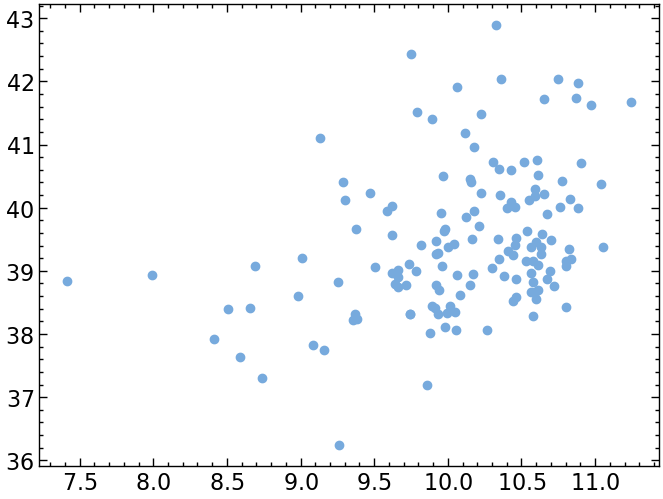

In [85]:
plt.scatter(t['logmass'], t['_log_lx'])

In [62]:
np.min((1-post_prob)[(1-post_prob)>0])

1.1102230246251565e-16

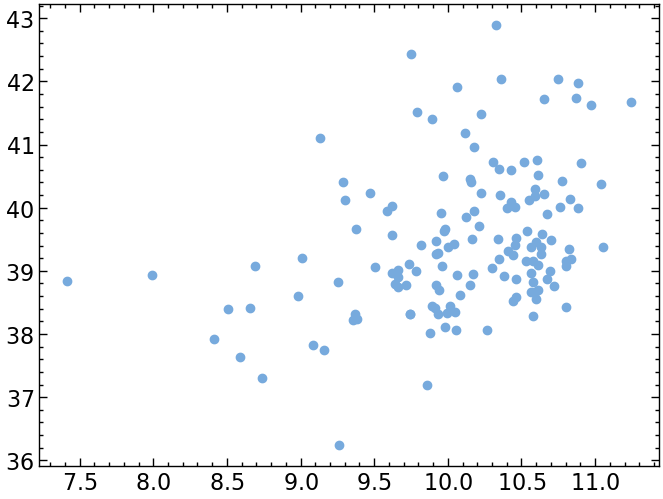

In [63]:
plt.scatter(data_50Mpc_out['logmass'], data_50Mpc_out['_log_lx'])

In [64]:
data_50Mpc_out

<Table length=145>
       objname           pgc   nsaid  group_id ...  logSFR logSFRerr   p_SF 
        str29           int32  int32   int32   ... float64  float64  float64
---------------------- ------- ------ -------- ... ------- --------- -------
2MASXJ15150097+5525555 3386892 139090       -1 ...   -1.74       0.3   -9.62
            ESO103-056   62320     -1      151 ...   -0.27       0.3   -6.96
            ESO121-006   18437     -1       -1 ...    -1.0       0.3  -19.48
            ESO320-030   37254     -1      175 ...    0.81       0.3  -16.91
            ESO383-035   47969     -1      239 ...    0.18       0.3  -25.33
            ESO443-017   44355     -1     3027 ...    0.41       0.3  -18.18
            ESO501-059   31588     -1      179 ...   -0.59       0.3  -18.22
            ESO512-020   52666     -1       -1 ...   -0.82       0.3  -18.25
            ESO548-029   13042     -1       25 ...   -2.13       0.3  -14.12
            ESO567-003   28995     -1       -1 ...   -1.07       0.3  -36.74
                   ...     ...    ...      ... ...     ...       ...     ...
             PGC027864   27864     50       -1 ...    -0.9       0.3    -0.1
             PGC029321   29321 361157     1978 ...    0.27       0.3   -5.05
             PGC035678   35678 661360       -1 ...   -1.29       0.3   -8.18
             PGC049191   49191 275961       -1 ...    -0.5       0.3   -8.19
            PGC1206166 1206166  75226     3007 ...    -2.6       0.3   -2.89
             PGC135069  135069     -1       -1 ...   -0.56       0.3  -12.89
             PGC679759  679759     -1       -1 ...   -1.56      0.42   -5.44
              UGC04730   25370 374316       -1 ...    0.24       0.3  -22.11
              UGC06732   36655 627284       -1 ...     0.3       0.3  -31.14
              UGC09215   51400 681071     3005 ...   -1.12      0.42  -10.89

In [65]:
# NGC4136
# PGC034493

In [66]:
# TODO: best dist error
# bestdist_error

In [67]:
data_50Mpc_out[data_50Mpc_out['objname']=='NGC4136']

<Table length=1>
objname  pgc  nsaid  group_id ...      W4mag        logSFR logSFRerr   p_SF 
 str29  int32 int32   int32   ...     float64      float64  float64  float64
------- ----- ------ -------- ... ---------------- ------- --------- -------
NGC4136 38618 627842     2993 ... 8.14799976348877   -3.24       0.3  -21.72

In [68]:
data_50Mpc_out[data_50Mpc_out['logmass']<8]

<Table length=2>
 objname     pgc   nsaid group_id ...  logSFR logSFRerr   p_SF 
  str29     int32  int32  int32   ... float64  float64  float64
---------- ------- ----- -------- ... ------- --------- -------
 PGC027864   27864    50       -1 ...    -0.9       0.3    -0.1
PGC1206166 1206166 75226     3007 ...    -2.6       0.3   -2.89

/tmp/tmp.iv8uLkOQDf/ipykernel_506675/1256762728.py:7: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


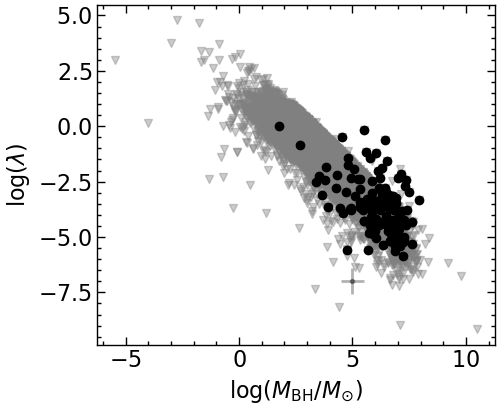

In [69]:
fig, ax = plt.subplots(1, 1, figsize=(5.2, 4.3))

#ax.scatter(x[yerr>0]+xp, y[yerr>0]+yp)

#sBHAR = 1 + (1 + y[yerr>0]) - np.log10(1.26*1e38 * .0025*10**(x[yerr>0]))

ax.legend()

ax.plot(x_bh[yerr>0], log_lam[yerr>0], marker='o', linestyle='none', color='k')

sx = 0.5
sy = np.sqrt(0.3**2 + 0.5**2)

ax.errorbar(5, -7, xerr=sx, yerr=sy, color='k', alpha=0.3, marker='.')

ax.plot(x_bh[log_lam < 10], log_lam[log_lam < 10], marker='v', linestyle='none', color='gray', zorder=-1, alpha=0.4)

ax.set_xlabel(r'$\log( M_{\rm{BH}}/M_{\odot} )$')
ax.set_ylabel(r'$\log(\lambda)$')
fig.tight_layout()
fig.savefig('erdfmass.pdf', dpi=300)

/tmp/tmp.iv8uLkOQDf/ipykernel_506675/3723278959.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


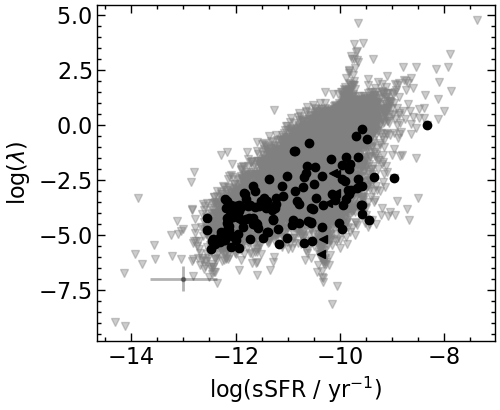

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(5.2, 4.3))

#ax.scatter(x[yerr>0]+xp, y[yerr>0]+yp)

#lambdaEdd = 1 + (1 + y) - np.log10(1.26*1e38 * .0025*10**(x))
#sBHAR = lambdaEdd/(.0025*10**(x[yerr>0]+xp))

sSFR = logsfr - ((x))

ax.legend()

sx = np.sqrt(0.4**2 + 0.5**2)
sy = np.sqrt(0.3**2 + 0.5**2)

ax.errorbar(-13, -7, xerr=sx, yerr=sy, color='k', alpha=0.3, marker='.')

masksfr = (yerr>0) & (logsfrerr == 0.3)
ax.plot(sSFR[masksfr], log_lam[masksfr], marker='o', linestyle='none', color='k')
masksfr = (yerr>0) & (logsfrerr > 0.3)
ax.plot(sSFR[masksfr], log_lam[masksfr], marker='<', linestyle='none', color='k')

ax.plot(sSFR[log_lam < 10], log_lam[log_lam < 10], marker='v', linestyle='none', color='gray', zorder=-1, alpha=0.4)

ax.set_xlabel(r'$\log( {\rm sSFR}\ /\ {\rm yr}^{-1} )$')
ax.set_ylabel(r'$\log( \lambda )$')
fig.tight_layout()
fig.savefig('erdfsfr.pdf', dpi=300)

In [71]:
## TODO:: color by stellar mass or something to see incompleteness

/home/cjb232/.conda/envs/cjb232base/lib/python3.11/site-packages/numpy/lib/function_base.py:4824: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  arr.partition(


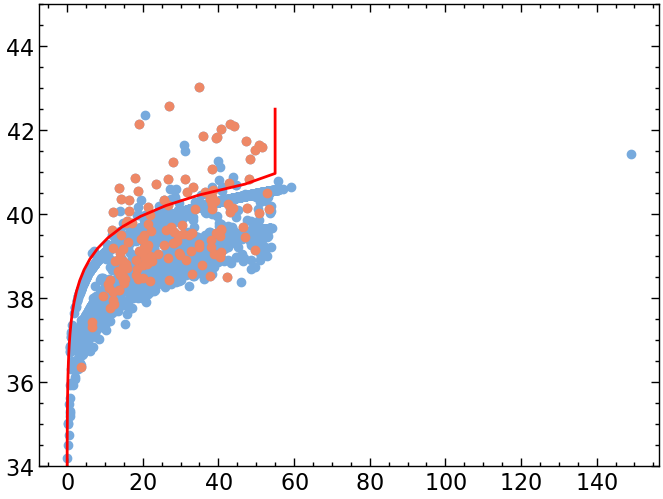

In [72]:
# 1/Vmax
log_l_eval = np.linspace(30, 42.5)
l_eval = 10**log_l_eval
sens_lim = 5 * 10**np.nanpercentile(np.log10(csc_results_sens['flux_sens_b'])[np.log10(csc_results_sens['flux_sens_b'])<30], 95)

#d = np.sqrt(l_eval / (sens_lim * 4*np.pi))
#d = (d*u.cm).to(u.Mpc).value
#Vmax = 4/3*np.pi*d**3
# CSC observations cover much less area than all-sky
# all-sky sensitivity is much lower than CSC

d = np.sqrt(l_eval / (sens_lim * 4*np.pi))
d = np.clip((d*u.cm).to(u.Mpc).value, 0, 55)
Vmax = 4/3*np.pi*d**3 * 130/180 # area
#log_l_med = np.log10(sens_med*4*np.pi*d**2)
plt.plot(d, log_l_eval, color='r')
plt.ylim(34, 45)

plt.scatter(dist, y)
plt.scatter(dist[yerr>0], y[yerr>0]) 

def invVmax_l(logl):
        return np.interp(logl, log_l_eval, 1/Vmax)


In [73]:
def logGSMF_blue(M_star):
    """
    Galaxy stellar mass function of the z ~ 0 blue+green galaxy population (single Schechter function)
    https://ui.adsabs.harvard.edu/abs/2012MNRAS.421..621B/abstract
    """
    M_br = 10**10.72
    phi = 0.71*1e-3
    alpha = -1.45
    phi = np.log(10) * np.exp(-M_star/M_br) * phi*(M_star/M_br)**(alpha+1)
    return phi

def logGSMF_red(M_star):
    """
    Galaxy stellar mass function of the z ~ 0 red galaxy population (double Schechter function)
    https://ui.adsabs.harvard.edu/abs/2012MNRAS.421..621B/abstract
    """
    M_br = 10**10.72
    phi1 = 3.25*1e-3
    phi2 = 0.08*1e-3
    alpha1 = -0.45
    alpha2 = -1.45
    phi_red = np.log(10) * np.exp(-M_star/M_br) * (phi1*(M_star/M_br)**(alpha1+1) + phi2*(M_star/M_br)**(alpha2+1))

    M_br = 10**10.72
    phi = 0.71*1e-3
    alpha = -1.45
    phi_blue = np.log(10) * np.exp(-M_star/M_br) * phi*(M_star/M_br)**(alpha+1)

    ratio = phi_red / (phi_red + phi_blue)
    
    return phi_red

In [74]:
def logGSMF(M_star, size=1):
    """
    Galaxy stellar mass function of the z ~ 0 blue+green galaxy population (single Schechter function)
    https://ui.adsabs.harvard.edu/abs/2012MNRAS.421..621B/abstract
    """
    logM_br = 10.78
    dlogM_br = 0.01
    
    phi1 = 2.96*1e-3
    dphi1 = 0.40*1e-3
    
    phi2 = 0.63*1e-3
    dphi2 = 0.10*1e-3
    
    alpha1 = -0.62
    dalpha1 = 0.03
    
    alpha2 = -1.50
    dalpha2 = 0.01
    
    M_br = 10**np.random.normal(loc=logM_br, scale=dlogM_br, size=size)
    phi1 = np.random.normal(loc=phi1, scale=dphi1, size=size)
    
    phi2 = np.random.normal(loc=phi2, scale=dphi2, size=size)
    
    alpha1 = np.random.normal(loc=alpha1, scale=dalpha1, size=size)
    alpha2 = np.random.normal(loc=alpha2, scale=dalpha2, size=size)

    # dN/dlogM
    phi = np.log(10) * np.exp(-M_star/M_br) * (phi1*(M_star/M_br)**(alpha1+1) + phi2*(M_star/M_br)**(alpha2+1))
    
    return phi

/tmp/tmp.iv8uLkOQDf/ipykernel_506675/3849495983.py:29: RuntimeWarning: invalid value encountered in divide
  ratio = phi_red / (phi_red + phi_blue)
/tmp/tmp.iv8uLkOQDf/ipykernel_506675/1946288822.py:100: RuntimeWarning: overflow encountered in power
  foccs[i,:] = 1/(1 + xii * np.exp(-theta2i*(logms - flat_samples[i,0])))**(1/xii)
/tmp/tmp.iv8uLkOQDf/ipykernel_506675/1946288822.py:143: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig1.show()
/tmp/tmp.iv8uLkOQDf/ipykernel_506675/1946288822.py:193: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig2.show()


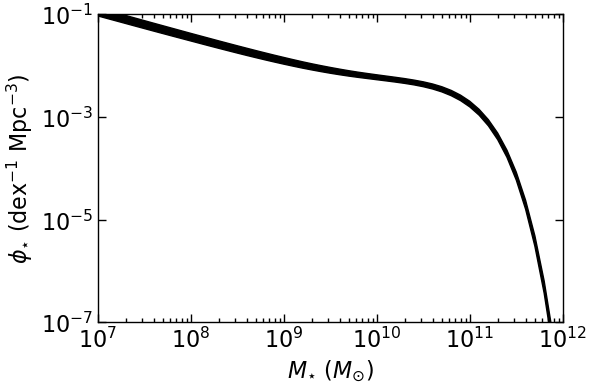

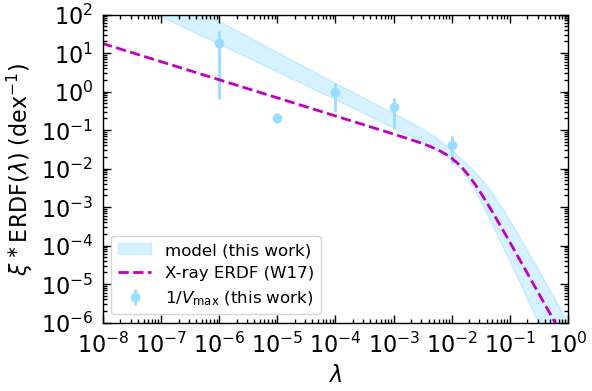

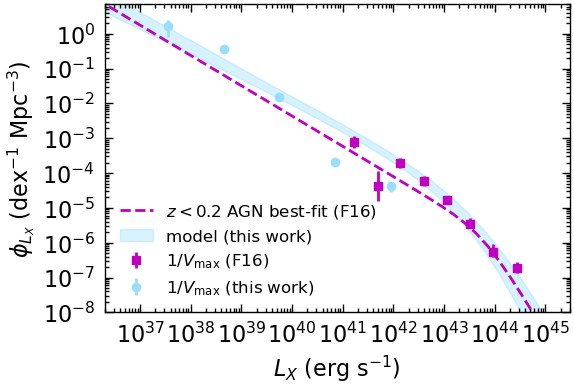

In [75]:
fig1, ax1 = plt.subplots(1, 1, figsize=(6, 4.0))
ax1.set_xscale('log')
ax1.set_yscale('log')

fig2, ax2 = plt.subplots(1, 1, figsize=(6, 4.0))
ax2.set_xscale('log')
ax2.set_yscale('log')

fig3, ax3 = plt.subplots(1, 1, figsize=(6, 4.0))
ax3.set_xscale('log')
ax3.set_yscale('log')

#TODO: Check bin center

# grid
dlogm = 0.1
logms = np.arange(2.0, 20.5, dlogm)
ms = 10**logms
dms = np.diff(ms)

dloglam = 0.01
loglam_eval = np.arange(-12., 4., dloglam)
lam_eval = 10**loglam_eval
dlam_eval = np.diff(lam_eval)

#Nsamp = 200
Nsamp = len(flat_samples)

gsmf = np.zeros([len(logms), Nsamp])
gsmf_blue = np.zeros([len(logms), Nsamp])
gsmf_red = np.zeros([len(logms), Nsamp])

bhmf1_blue = np.zeros([len(logms), Nsamp])
bhmf1_red = np.zeros([len(logms), Nsamp])

# BHOF should not depend on galaxy color type
bhmf_xray = np.zeros([len(logms), Nsamp])
bhmf_xray_blue = np.zeros([len(logms), Nsamp])
bhmf_xray_red = np.zeros([len(logms), Nsamp])

bhmf_radio = np.zeros([len(logms), Nsamp])
bhmf_radio_blue = np.zeros([len(logms), Nsamp])
bhmf_radio_red = np.zeros([len(logms), Nsamp])

bhmf_optical = np.zeros([len(logms), Nsamp])
bhmf_optical_blue = np.zeros([len(logms), Nsamp])
bhmf_optical_red = np.zeros([len(logms), Nsamp])

bhlf = np.zeros([len(logms), Nsamp])
bhlf_conv = np.zeros([len(logms), Nsamp])


erdfs = np.zeros([len(loglam_eval), Nsamp])


foccs = np.zeros([Nsamp, len(logms)])

#focc_radio = np.load('focc_vlass.npy')
#focc_optical = np.load('focc_ptf.npy')

for i in range(Nsamp):

    # total BH mass function is dominated by early population
    # GSH20, early-type / E, limits
    alpha_red = np.random.normal(7.89, 0.09, size=1)
    beta_red = np.random.normal(1.33, 0.12, size=1)
    sigma_red = np.random.normal(0.65, 0.05, size=1)
    logms0_red = np.log10(3*1e10)

    # grid
    logmb_red = alpha_red + beta_red*(logms - logms0_red)
    mb_red = 10**logmb_red
    dmb_red = np.diff(mb_red)

    # BH mass - stellar mass relation
    # RV15 / similar to GSH20, early-type
    alpha_blue = np.random.normal(7.45, 0.08, size=1)
    beta_blue = np.random.normal(1.05, 0.11, size=1)
    sigma_blue = np.random.normal(np.sqrt(0.55**2 - 0.35**2), 0.02, size=1) # Assume 10% error on scatter
    logms0_blue = 11

    # grid
    logmb_blue = alpha_blue + beta_blue*(logms - logms0_blue)
    mb_blue = 10**logmb_blue
    dmb_blue = np.diff(mb_blue)
    
    x_bh_eval = 6.70 + 1.61*(logms - np.log10(3e10)) # Late-type (AGN)
    logl = -1 + 38.2 + x_bh_eval
    l = 10**logl
    dl = np.diff(l)
    dlogl = np.diff(logl)[0]

    gsmf[:,i] = logGSMF(ms)
    gsmf_blue[:,i] = logGSMF_blue(ms)
    gsmf_red[:,i] = logGSMF_red(ms)

    # Occupation fraction
    xii = flat_samples[i,7]
    theta2i = flat_samples[i,8]
    foccs[i,:] = 1/(1 + xii * np.exp(-theta2i*(logms - flat_samples[i,0])))**(1/xii)

    # Convolve
    delta1 = flat_samples[i,1]
    ep = flat_samples[i,2]
    lam_s = 10**flat_samples[i,4]
    C = 1/trapezoid( ( (lam_eval/lam_s)**delta1 + (lam_eval/lam_s)**(delta1+ep) )**(-1), dx=np.diff(lam_eval))
    pdf_pl = C * ( (lam_eval/lam_s)**delta1 + (lam_eval/lam_s)**(delta1+ep) )**(-1)
    erdfs[:,i] = pdf_pl

    BC = 1

    bhmfi = np.array([np.trapz(foccs[i,:] * gsmf[:,i] * st.norm.pdf(logmbi-logms, loc=logmb_blue-logms, scale=sigma_blue)*dlogm) for logmbi in logmb_blue])
    bhlf[:,i] = np.array([np.trapz(np.interp(logli - loglam_eval, logmb_blue + 38.2 - BC, bhmfi) * pdf_pl * dloglam) for logli in logl])

    # int per dex * dex PDF = per dex
    # # PDF units are in per dex! ##


# FOTOPOLOU DENSITY
Gamma = 1.8

gamma1 = 0.87
gamma2 = 2.40
A = 10**-5.97
L0 = 10**43.77
L = np.logspace(36, 47)
# # https://www.aanda.org/articles/aa/pdf/2016/03/aa24763-14.pdf
#L_F16 = L*(10**(2-Gamma) - 5**(2-Gamma))/(10**(2-Gamma) - 2**(2-Gamma))
LF_F16 = A/((L/L0)**(gamma1) + (L/L0)**gamma2)  # Now this is in 2-10 keV band
LF_F16 = LF_F16 * (10**(2-Gamma) - 2**(2-Gamma))/(10**(2-Gamma) - 5**(2-Gamma))

#########################################
# GSMF
#########################################

# Plot
ax1.fill_between(ms[:-1], np.percentile(gsmf[:-1], 16, axis=1),
           np.percentile(gsmf[:-1], 84, axis=1), color='k')
ax1.set_ylim(1e-7, 1e-1)
ax1.set_xlim(1e7, 1e12)
ax1.set_xlabel(r'$M_{\star}\ (M_{\odot})$')
ax1.set_ylabel(r'$\phi_{\star}$ (dex$^{-1}$ Mpc$^{-3})$')
fig1.show()

#########################################
# ERDF
#########################################

# Normalize
xi_star = np.ones(np.shape(bhlf)[1])
for i in range(np.shape(bhlf)[1]):
        xi_star[i] = np.interp(1e43, L, (10**(2-Gamma) - 2**(2-Gamma))/(10**(2-Gamma) - 5**(2-Gamma)) * LF_F16) / np.interp(1e43, l, bhlf[:,i])
        erdfs[:,i] = erdfs[:,i]*xi_star[i]

bhlf = bhlf*np.median(xi_star)

# Plot
nnn = 1e-2
ax2.fill_between(lam_eval[:-1], nnn * np.percentile(erdfs[:-1], 16, axis=1)/dloglam,
           nnn * np.percentile(erdfs[:-1], 84, axis=1)/dloglam, color=color, alpha=0.4, label='model (this work)')

# 1/Vmax
x_bh = 6.70 + 1.61*(x - np.log10(3e10)) # Late-type (AGN)
BC = 1 # Bolometric correction
log_lam = y + BC - 38.2 - x_bh # residual

_dloglam = 1.0
_loglam_eval = np.arange(-8.5, -1, _dloglam)
#h, bin_edges = np.histogram(log_lam[yerr>0], bins=_loglam_eval)
num, bin_edges = np.histogram((log_lam)[(yerr > 0)][(post_prob > .5)], weights=invVmax_l(y)[(yerr > 0)][(post_prob > .5)]/p_obs[(yerr > 0)][(post_prob > .5)], bins=_loglam_eval)
err, bin_edges = np.histogram((log_lam)[(yerr > 0)][(post_prob > .5)], weights=(invVmax_l(y)[(yerr > 0)][(post_prob > .5)]/p_obs[(yerr > 0)][(post_prob > .5)])**2, bins=_loglam_eval)

norm = 1*np.diff(bin_edges)
ax2.errorbar(10**(bin_edges[:-1]+_dloglam/2), num/norm, yerr=np.sqrt(err)/norm, linestyle='none',
        color=color, marker='o', label=r'$1/V_{\rm{max}}$ (this work)')

_loglam_eval = np.arange(-8.5, 0, 0.1)
ax2.plot(10**_loglam_eval, 10**-1.65 * ((10**_loglam_eval/10**-1.84)**(0.47) + (10**_loglam_eval/10**-1.84)**(0.47+2.22))**-1,
color='m', linestyle='dashed', label='X-ray ERDF (W17)')

"""
xi_star_birchall = 1 #3e-2
c = (10**(2-Gamma) - 2**(2-Gamma))/(12**(2-Gamma) - 2**(2-Gamma))
ax2.fill_between(c*np.array([10**-3.56, 10**-2.45]), xi_star_birchall*np.array([8.535e-2, 2.414e-3]), xi_star_birchall*np.array([2.5e-2, 1.45e-3]),
        color='pink', alpha=0.8, label=r'$M_{\star}{=}10^{9{-}9.5} M_{\odot}$ (B20)')
ax2.fill_between(c*np.array([10**-3.25, 10**-1.53]), xi_star_birchall*np.array([0.015,  0.000295]), xi_star_birchall*np.array([0.04489, 0.001044]),
        color='lightpink', alpha=0.4, label=r'$M_{\star}{=}10^{8{-}9} M_{\odot}$ (B20)')
"""        
ax2.set_ylim(1e-6, 1e2)
ax2.set_xlim(1e-8, 1e0)
ax2.set_xlabel(r'$\lambda$')
ax2.set_ylabel(r'$\xi^\ast$ERDF$({\lambda})$ (dex$^{-1}$)')
fig2.show()

#########################################
# LF
#########################################

# Fotopolou
ax3.plot(L, LF_F16, color='m', linestyle='dashed', label='$z<0.2$ AGN best-fit (F16)')

#f_cont = ascii.read('fotopoulou_cont.dat')
#Lb = (10**(2-Gamma) - 2**(2-Gamma))/(10**(2-Gamma) - 5**(2-Gamma))*10**f_cont[:20]['col1'] # 0.5-7
#ax3.fill_between(Lb, 10**f_cont[:20]['col2'], 10**np.interp(f_cont[:20]['col1'], f_cont[20:]['col1'], f_cont[20:]['col2']),
#        color='m', label=r'$z<0.2$ AGN model (F16)', alpha=0.2, lw=0)

dat = ascii.read('fotopoulou_dat.txt')
dat_hi = ascii.read('fotopoulou_hi.txt')
dat_lo = ascii.read('fotopoulou_lo.txt')

Lb =  10**dat['col1'].data # 0.5-7

errs = (10**(2-Gamma) - 2**(2-Gamma))/(10**(2-Gamma) - 5**(2-Gamma)) * np.array([10**dat['col2'] - 10**dat_lo['col2'], 10**dat_hi['col2'] - 10**dat['col2']])
ax3.errorbar(Lb, (10**(2-Gamma) - 2**(2-Gamma))/(10**(2-Gamma) - 5**(2-Gamma)) * 10**dat['col2'], yerr=errs, linestyle='none', marker='s', color='m', label=r'$1/V_{\rm{max}}$ (F16)')

bins = np.linspace(37., 42.5, 6)
num, bins = np.histogram((y)[(yerr > 0)][(post_prob > .5)], weights=invVmax_l(y)[(yerr > 0)][(post_prob > .5)]/p_obs[(yerr > 0)][(post_prob > .5)], bins=bins)
err, bins = np.histogram((y)[(yerr > 0)][(post_prob > .5)], weights=(invVmax_l(y)[(yerr > 0)][(post_prob > .5)]/p_obs[(yerr > 0)][(post_prob > .5)])**2, bins=bins)
bin_width = (bins[:-1] + bins[1:])
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_widths = 2.303*np.diff(bins) * 10**bin_centers
ax3.errorbar(10**bin_centers, num/np.diff(bins), yerr=np.sqrt(err)/np.diff(bins),
             linestyle='none', marker='o', color=color, label=r'$1/V_{\rm{max}}$ (this work)')

ax3.fill_between((l[:-1]), (np.percentile(bhlf[:-1], 16, axis=1)),
                (np.percentile(bhlf[:-1], 84, axis=1)), color=color, alpha=0.4, label='model (this work)')

# Axis
for ax in [ax2, ax3]:
        locmaj = matplotlib.ticker.LogLocator(base=10,numticks=14) 
        ax.xaxis.set_major_locator(locmaj)
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=14)
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        ax.tick_params(axis='x', which='major', pad=7)

        locmaj = matplotlib.ticker.LogLocator(base=10,numticks=14) 
        ax.yaxis.set_major_locator(locmaj)
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9),numticks=14)
        ax.yaxis.set_minor_locator(locmin)
        ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        ax.tick_params(axis='y', which='major', pad=7)

#ax3.set_xlim(1e37, 1e48)
ax3.set_xlim(2e36, 3e45)
ax3.set_ylim(1e-8, 7e0)
ax3.set_xlabel(r'$L_{X}$ (erg s$^{-1}$)')
ax3.set_ylabel(r'$\phi_{L_X}$ (dex$^{-1}$ Mpc$^{-3})$')
ax2.legend(fontsize=12, frameon=True, loc='lower left')
ax3.legend(fontsize=12)

fig2.savefig('erdfxray.pdf', dpi=300)
fig3.savefig('lfxray.pdf', dpi=300)

### Fundamental Plane

In [76]:
dat_fp = ascii.read('gultiken.txt', format='tab', guess=False)
dat_fp

<Table length=105>
    Source     Dist.  References ... References_4 Notes  col15
    str13     float64   int64    ...     str5      str6  int64
------------- ------- ---------- ... ------------ ------ -----
MGC-02-36-002   152.4          1 ...            4 ^a^,^b    --
      IC 4296    49.2          1 ...            7  cdots    --
     Circinus    2.82          1 ...            7 ^c^,^b    --
     Cygnus A   242.7          1 ...            7 ^a^,^c    --
       Galaxy 0.00828          1 ...           15  cdots    --
       Galaxy 0.00828          1 ...           15  cdots    --
       Galaxy 0.00828          1 ...           16  cdots    --
      IC 1459   28.92          1 ...            7  cdots    --
      IC 1481    89.9          1 ...        cdots     ^a    --
      IC 2560    37.2          1 ...            4     ^c    --
          ...     ...        ... ...          ...    ...   ...
     NGC 6264   147.6          1 ...        cdots     ^a    --
     NGC 6323   113.4          1 ...        cdots     ^a    --
     NGC 6861   28.71          1 ...            4     ^a    --
     NGC 7052    70.4          1 ...            7     ^a    --
     NGC 7457   12.53          1 ...           48     ^a    --
     NGC 7582    22.3          1 ...            7  cdots    --
     NGC 7619   53.85          1 ...            4     ^a    --
     NGC 7768   116.0          1 ...        cdots     ^a    --
     UGC 3789    49.9          1 ...        cdots     ^a    --
     UGC 9799   151.1         25 ...            7     ^a    --

In [77]:
fx = [si.split('_')[0].replace('${','').replace('}','')[:4] for si in dat_fp['F_X']]
t = [(fxi, i) for (i, fxi) in enumerate(fx) if not fxi.startswith('<') and not fxi.startswith('cdot')]
fx = np.array([ti[0] for ti in t], dtype=float)
mask_x = np.array([ti[1] for ti in t])

fxexp = [si.split('^')[-1].replace('{','').replace('}$','') for si in dat_fp['F_X']]
fxexp = np.array(fxexp)[mask_x].astype(int)

fx = fx*10.**fxexp


distfp = dat_fp['Dist.'][mask_x]
F2L = 4*np.pi*(distfp*u.Mpc)**2

fx = (fx*u.erg/u.s/u.cm**2 * F2L).to(u.erg/u.s).value

fxs = np.zeros(len(dat_fp))
fxs[mask_x] = fx

In [78]:
fr = [si.split('_')[0].replace('${','').replace('}','')[:4] for si in dat_fp['S_nu']]
t = [(fri, i) for (i, fri) in enumerate(fr) if not fri.startswith('<') and not fri.startswith('cdot')]
fr = np.array([ti[0] for ti in t], dtype=float)
mask_r = np.array([ti[1] for ti in t])

distfp = dat_fp['Dist.'][mask_r]
F2L = 4*np.pi*(distfp*u.Mpc)**2

nu = np.array(dat_fp['nu'][mask_r], dtype=float)*u.GHz

fr = (fr*u.mJy * F2L).to(u.erg/u.s, equivalencies=u.spectral_density(nu)).value

frs = np.zeros(len(dat_fp))
frs[mask_r] = fr

In [79]:
m = [si.split('_')[0].replace('${','').replace('}','')[:4] for si in dat_fp['M_BH']]
t = [(mi, i) for (i, mi) in enumerate(m) if not mi.startswith('<') and not mi.startswith('cdot')]
m = np.array([ti[0] for ti in t], dtype=float)
mask_m = np.array([ti[1] for ti in t])

mexp = [si.split('^')[-1].replace('{','').replace('}$','') for si in dat_fp['M_BH']]
mexp = np.array(mexp)[mask_m].astype(int)

m = m*10**mexp

ms = np.zeros(len(dat_fp))
ms[mask_m] = m

/tmp/tmp.iv8uLkOQDf/ipykernel_506675/2726803966.py:3: RuntimeWarning: divide by zero encountered in log10
  log_l_vlass = np.log10((10**data_50Mpc['log_l_vlass']*u.mJy*u.cm**2).to(u.erg/u.s, equivalencies=u.spectral_density(3*u.GHz)).value)
/tmp/tmp.iv8uLkOQDf/ipykernel_506675/2726803966.py:4: RuntimeWarning: invalid value encountered in divide
  dlog_l_vlass = data_50Mpc['l_vlass_err']/(10**data_50Mpc['log_l_vlass']) * 10**log_l_vlass
/tmp/tmp.iv8uLkOQDf/ipykernel_506675/2726803966.py:12: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(0.60*np.log10(fxs) + 0.78*np.log10(ms) + 7.33, np.log10(frs),


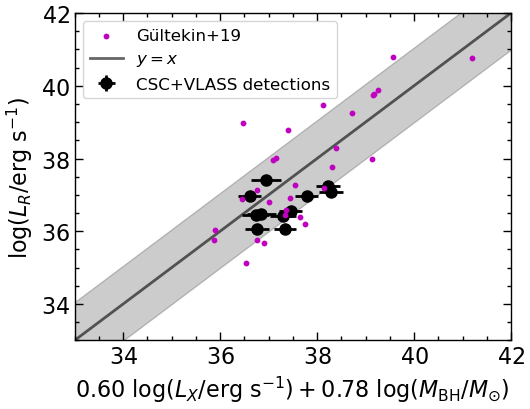

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4.3))

log_l_vlass = np.log10((10**data_50Mpc['log_l_vlass']*u.mJy*u.cm**2).to(u.erg/u.s, equivalencies=u.spectral_density(3*u.GHz)).value)
dlog_l_vlass = data_50Mpc['l_vlass_err']/(10**data_50Mpc['log_l_vlass']) * 10**log_l_vlass
dlog_l_vlass = 0.434 * dlog_l_vlass / 10**log_l_vlass

mask = mask_b & mask_virgo & mask_fornax & np.isfinite(_x) & np.isfinite(_y) & np.isfinite(_xerr) & np.isfinite(_yerr) & \
    (data_50Mpc['z_dr16'] < 0.012) & (data_50Mpc['z_gama'] < 0.012) & (_y > 0) & (data_50Mpc['l_vlass_err'] > 0) & (data_50Mpc['_log_lx_err'] > 0)
#mask = (data_50Mpc['log_l_vlass_err'] > 0) & (data_50Mpc['_log_lx_err'] > 0)
logM = np.log10(0.0025*10**data_50Mpc['logmass'][mask])

ax.scatter(0.60*np.log10(fxs) + 0.78*np.log10(ms) + 7.33, np.log10(frs),
           color='m', label=r'Gültekin+19', marker='o', s=10, zorder=40)

ax.errorbar(0.60*data_50Mpc['_log_lx'][mask] + 0.78*logM + 7.33, log_l_vlass[mask], linestyle='none', marker='o',
           color='k', label=r'CSC+VLASS detections', markersize=8, xerr=np.sqrt((0.60*data_50Mpc['_log_lx_err'][mask])**2 + (0.78*0.3)**2),
           yerr=dlog_l_vlass[mask])

xx = np.linspace(32, 43)
ax.plot(xx, xx, color='k', label=r'$y=x$', alpha=0.6)
s = np.sqrt(.9**2 + 0.5**2)
ax.fill_between(xx, xx-s, xx+s, color='k', alpha=0.2)

#data_50Mpc['logmass'][mask
# These are very low L_bol/L_Edd < 1e-5 

ax.legend(fontsize=12, frameon=True)

ax.set_xlabel(r'$0.60\ \log (L_X/ {\rm{erg}}\ {\rm{s}}^{-1} ) + 0.78\ \log(M_{\rm{BH}}/M_{\odot})$')
ax.set_ylabel(r'$\log( L_R / $erg s$^{-1}$)')

ax.set_xlim(33, 42)
ax.set_ylim(33, 42)

fig.tight_layout()
fig.savefig('fp.pdf', dpi=300)

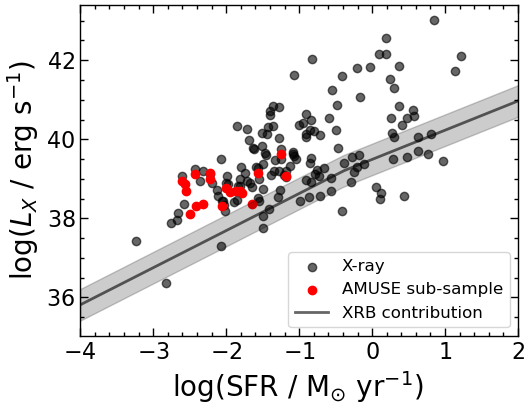

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(5.5, 4.3))

ax.scatter(logsfr[yerr>0], y[yerr>0], color='k', alpha=0.6, label='X-ray')

mask = data_50Mpc['_log_lx_err'][idx_result]>0
ax.scatter(data_50Mpc['logSFR'][idx_result][mask], data_50Mpc['_log_lx'][idx_result][mask], color='r', label='AMUSE sub-sample')

logsfr_eval = np.linspace(-4, 2, 1000)
mask = 10**logsfr_eval < 0.4

lehmer = 39.57 + 0.94*logsfr_eval
lehmer[~mask] = 39.49 + 0.74*logsfr_eval[~mask]

ax.fill_between(logsfr_eval, lehmer - 0.4, lehmer + 0.4, alpha=0.2, color='k')
ax.plot(logsfr_eval, lehmer, alpha=0.6, color='k', label=r'XRB contribution')

#plt.fill_between(logsfr_eval[~mask], 39.49 + 0.74*logsfr_eval[~mask] - 0.4, 39.49 + 0.74*logsfr_eval[~mask] + 0.4, alpha=0.2, color='k')

#plt.fill_between(logsfr_eval, 39.57 + 0.94*logsfr_eval - 3*0.4, 39.57 + 0.94*logsfr_eval + 3*0.4, alpha=0.2, lw=2, linestyle='dotted')
ax.set_xlim(-4, 2)
ax.set_xlabel(r'$\log( \rm{SFR}\ /\ M_{\odot}\ {\rm{yr}}^{-1} )$ ', fontsize=20)
ax.set_ylabel(r'$\log( L_X\ /\ {\rm{erg}}\ {\rm{s}}^{-1})$', fontsize=20)

ax.legend(fontsize=12, frameon=True)

fig.tight_layout()
fig.savefig('LSFR.pdf', dpi=300)

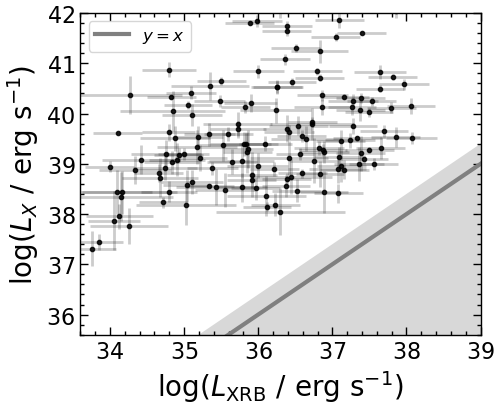

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(5.2, 4.3))

#ax.scatter(logsfr[yerr>0], y[yerr>0]+yp, color='k', alpha=0.6, label='X-ray')

lehmer = np.log10( 9.05*1e28* 10**(x[yerr>0]) + 1.62*1e39  *10**logsfr[yerr>0] ) #[mask]
#lehmer[~mask] = 39.49 + 0.74*logsfr_eval[~mask]

b = 2*n - 1/3
#lehmer += np.log10(gammainc(2*n[yerr>0], b*(1/60)**1/n[yerr>0])/gamma(2*n[yerr>0]))
alpha = ((2*r_match)/d25)
lehmer += np.log10(gammainc(2*n, b*alpha**(1/n)) / gammainc(2*n, b))[yerr>0]

#ax.fill_between(logsfr_eval, lehmer - 0.4, lehmer + 0.4, alpha=0.2, color='k')
ax.errorbar(lehmer, y[yerr>0], yerr=yerr[yerr>0], xerr=xerr[yerr>0], 
            linestyle='none', marker='.',alpha=0.2, color='k')
ax.errorbar(lehmer, y[yerr>0], 
            linestyle='none', marker='.',alpha=0.8, color='k')

#mask = data_50Mpc['_log_lx_err'][idx_result]>0
#lehmer = np.log10( 9.05*1e28* 10**(x[(yerr>0) & mask] + xp) + 1.62*1e39  *10**logsfr[(yerr>0) & mask] )

#ax.errorbar(lehmer[mask], y[(yerr>0) & mask]+yp, 
#            linestyle='none', marker='.',alpha=0.8, color='k')

#plt.fill_between(logsfr_eval[~mask], 39.49 + 0.74*logsfr_eval[~mask] - 0.4, 39.49 + 0.74*logsfr_eval[~mask] + 0.4, alpha=0.2, color='k')

#plt.fill_between(logsfr_eval, 39.57 + 0.94*logsfr_eval - 3*0.4, 39.57 + 0.94*logsfr_eval + 3*0.4, alpha=0.2, lw=2, linestyle='dotted')
#ax.set_xlim(-4, 2)

xx = np.linspace(35, 42)
ax.plot(xx, xx, color='gray', lw=3, label=r'$y=x$')
ax.fill_between(xx, xx+0.4, xx- 100, color='gray', lw=0, alpha=0.3)

ax.set_xlim(33.6, 39)
ax.set_ylim(35.6, 42)

ax.set_xlabel(r'$\log( L_{\rm XRB}\ /\ {\rm{erg}}\ {\rm{s}}^{-1})$', fontsize=20)
ax.set_ylabel(r'$\log( L_X\ /\ {\rm{erg}}\ {\rm{s}}^{-1})$', fontsize=20)

ax.legend(fontsize=12, frameon=True)

fig.tight_layout()
fig.savefig('LSFR.pdf', dpi=300)